In [42]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/btc_1m_futures_data_imputed.csv')

In [43]:
display(df.head())

Unnamed: 0           symbol     open     high      low    close  \
0  2021-12-31 16:00:00  BTC-USDT-220107  47952.0  47973.2  47886.1  47952.9   
1  2021-12-31 16:01:00  BTC-USDT-220107  47953.6  47958.7  47899.2  47899.2   
2  2021-12-31 16:02:00  BTC-USDT-220107  47898.5  47939.0  47896.3  47916.5   
3  2021-12-31 16:03:00  BTC-USDT-220107  47915.4  47921.7  47867.0  47902.0   
4  2021-12-31 16:04:00  BTC-USDT-220107  47904.6  47915.0  47888.4  47906.2   

   volume  
0  1420.0  
1   386.0  
2   157.0  
3   118.0  
4    97.0

In [44]:
df.columns = ['timestamp', 'symbol', 'open', 'high', 'low', 'close', 'volume']
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [45]:
symbols = df['symbol'].unique()

liquidity_data = []

for symbol in symbols:
    symbol_df = df[df['symbol'] == symbol].copy()
    symbol_df['timestamp'] = pd.to_datetime(symbol_df['timestamp'])
    symbol_df.set_index('timestamp', inplace=True)
    
    symbol_df['notional_liquidity'] = symbol_df['close'] * symbol_df['volume']

    liquidity_data.append({'symbol' : symbol, 'liquidity': symbol_df['notional_liquidity'].mean()})

notional_liquidity = pd.DataFrame(liquidity_data)

In [46]:
display(df)

timestamp           symbol     open     high      low  \
0       2021-12-31 16:00:00  BTC-USDT-220107  47952.0  47973.2  47886.1   
1       2021-12-31 16:01:00  BTC-USDT-220107  47953.6  47958.7  47899.2   
2       2021-12-31 16:02:00  BTC-USDT-220107  47898.5  47939.0  47896.3   
3       2021-12-31 16:03:00  BTC-USDT-220107  47915.4  47921.7  47867.0   
4       2021-12-31 16:04:00  BTC-USDT-220107  47904.6  47915.0  47888.4   
...                     ...              ...      ...      ...      ...   
5133470 2024-12-31 23:55:00  BTC-USDT-250627  99609.1  99626.7  99594.6   
5133471 2024-12-31 23:56:00  BTC-USDT-250627  99619.5  99639.4  99586.6   
5133472 2024-12-31 23:57:00  BTC-USDT-250627  99588.6  99588.6  99554.8   
5133473 2024-12-31 23:58:00  BTC-USDT-250627  99552.7  99558.6  99552.7   
5133474 2024-12-31 23:59:00  BTC-USDT-250627  99542.4  99568.5  99512.3   

           close  volume  
0        47952.9  1420.0  
1        47899.2   386.0  
2        47916.5   157.0  
3        47902.0   118.0  
4        47906.2    97.0  
...          ...     ...  
5133470  99626.7     1.9  
5133471  99586.6     1.9  
5133472  99554.8     1.4  
5133473  99556.9     1.6  
5133474  99515.1     1.6  

[5133475 rows x 7 columns]

In [47]:
notional_liquidity['liquidity'] = notional_liquidity['liquidity'].replace({',': ''}, regex=True).astype(float)

notional_liquidity = notional_liquidity.sort_values(by='liquidity', ascending=False)

In [48]:
display(notional_liquidity)

symbol     liquidity
11   BTC-USDT-220325  4.289714e+07
7    BTC-USDT-220225  1.647390e+07
24   BTC-USDT-220624  1.558630e+07
6    BTC-USDT-220218  1.469165e+07
3    BTC-USDT-220128  1.464794e+07
..               ...           ...
133  BTC-USDT-240726  5.710448e+05
144  BTC-USDT-241011  5.512332e+05
146  BTC-USDT-241025  4.598291e+05
138  BTC-USDT-240830  4.467161e+05
159  BTC-USDT-250228  4.265065e+05

[162 rows x 2 columns]

In [49]:
def parse_expiry(symbol):
    date_str = symbol.split('-')[-1]
    year = int('20' + date_str[:2])
    month = int(date_str[2:4])
    day = int(date_str[4:6])
    return pd.Timestamp(year=year, month=month, day=day)

df['expiry_date'] = df['symbol'].apply(parse_expiry)


In [50]:
dataset_end = df['timestamp'].max()
dataset_end_ts = pd.to_datetime(dataset_end)
contract_info = []

for symbol, group in df.groupby('symbol'):
    expiry = group['expiry_date'].iloc[0]
    expiry_ts = pd.to_datetime(expiry)
    data_start = group['timestamp'].min()
    data_end = min(expiry, dataset_end_ts)
    contract_info.append({
        'contract_name': symbol,
        'expiry_date': expiry,
        'data_start_date': data_start,
        'data_end_date': data_end
    })

contract_df = pd.DataFrame(contract_info)


In [51]:
from itertools import combinations

pairs = []

for a, b in combinations(contract_df.itertuples(index=False), 2):
    if a.contract_name == b.contract_name:
        continue
    if a.expiry_date < b.expiry_date:
        near, far = a, b
    else:
        near, far = b, a
    if near.expiry_date == far.expiry_date:
        continue
    
    near_start = pd.to_datetime(near.data_start_date)
    far_start = pd.to_datetime(far.data_start_date)
    near_end = pd.to_datetime(near.data_end_date)
    far_end = pd.to_datetime(far.data_end_date)
    
    overlap_start = max(near_start, far_start)
    overlap_end = min(near_end, far_end)
    
    if overlap_start < overlap_end:
        pairs.append({
            'near_contract': near.contract_name,
            'far_contract': far.contract_name,
            'near_expiry': near.expiry_date,
            'far_expiry': far.expiry_date,
            'overlap_start': overlap_start,
            'overlap_end': overlap_end
        })

pairs_df = pd.DataFrame(pairs)


In [52]:
from itertools import combinations
import pandas as pd

contract_df['expiry_date'] = pd.to_datetime(contract_df['expiry_date'])
contract_df['data_start_date'] = pd.to_datetime(contract_df['data_start_date'])
contract_df['data_end_date'] = pd.to_datetime(contract_df['data_end_date'])

triplets = []

for t1, t2, t3 in combinations(contract_df.itertuples(index=False), 3):
    if not (t1.expiry_date < t2.expiry_date < t3.expiry_date):
        continue
    
    overlap_start = max(pd.to_datetime(t1.data_start_date),
                        pd.to_datetime(t2.data_start_date),
                        pd.to_datetime(t3.data_start_date))
    overlap_end   = min(pd.to_datetime(t1.data_end_date),
                        pd.to_datetime(t2.data_end_date),
                        pd.to_datetime(t3.data_end_date))
    
    if overlap_start < overlap_end:
        triplets.append({
            'tenor1_contract': t1.contract_name,
            'tenor2_contract': t2.contract_name,
            'tenor3_contract': t3.contract_name,
            'tenor1_expiry': t1.expiry_date,
            'tenor2_expiry': t2.expiry_date,
            'tenor3_expiry': t3.expiry_date,
            'overlap_start': overlap_start,
            'overlap_end': overlap_end
        })

triplets_df = pd.DataFrame(triplets)


In [53]:
butterfly_triplets = pd.DataFrame()

for idx, row in triplets_df.iterrows():
    # Unpack triplet info
    t1, t2, t3 = row['tenor1_contract'], row['tenor2_contract'], row['tenor3_contract']
    t1_exp, t2_exp, t3_exp = row['tenor1_expiry'], row['tenor2_expiry'], row['tenor3_expiry']
    start, end = row['overlap_start'], row['overlap_end']

    # Slice data for this window and contracts
    df1 = df[(df['symbol'] == t1) & (df['timestamp'] >= start) & (df['timestamp'] <= end)][['timestamp', 'close']].rename(columns={'close': 'close1'})
    df2 = df[(df['symbol'] == t2) & (df['timestamp'] >= start) & (df['timestamp'] <= end)][['timestamp', 'close']].rename(columns={'close': 'close2'})
    df3 = df[(df['symbol'] == t3) & (df['timestamp'] >= start) & (df['timestamp'] <= end)][['timestamp', 'close']].rename(columns={'close': 'close3'})

    # Merge on timestamp (inner join, keeps only fully observed minutes)
    merged_triplet = df1.merge(df2, on='timestamp').merge(df3, on='timestamp')
    merged_triplet['tenor1_contract'] = t1
    merged_triplet['tenor2_contract'] = t2
    merged_triplet['tenor3_contract'] = t3

    butterfly_triplets = pd.concat([butterfly_triplets, merged_triplet], ignore_index=True)

In [54]:
butterfly_triplets.head()

timestamp   close1   close2   close3  tenor1_contract  \
0 2021-12-31 16:00:00  47952.9  48006.6  48970.1  BTC-USDT-220107   
1 2021-12-31 16:01:00  47899.2  47952.8  48937.3  BTC-USDT-220107   
2 2021-12-31 16:02:00  47916.5  47963.2  48953.4  BTC-USDT-220107   
3 2021-12-31 16:03:00  47902.0  47938.7  48926.2  BTC-USDT-220107   
4 2021-12-31 16:04:00  47906.2  47943.0  48930.7  BTC-USDT-220107   

   tenor2_contract  tenor3_contract  
0  BTC-USDT-220114  BTC-USDT-220325  
1  BTC-USDT-220114  BTC-USDT-220325  
2  BTC-USDT-220114  BTC-USDT-220325  
3  BTC-USDT-220114  BTC-USDT-220325  
4  BTC-USDT-220114  BTC-USDT-220325

In [11]:
butterfly_triplets = pd.read_csv('../data/butterfly_triplets.csv')

display(butterfly_triplets)

#butterfly_triplets.to_csv('../data/butterfly_triplets.csv', index=False)

timestamp   close1   close2   close3  tenor1_contract  \
0        2021-12-31 16:00:00  47952.9  48006.6  48970.1  BTC-USDT-220107   
1        2021-12-31 16:01:00  47899.2  47952.8  48937.3  BTC-USDT-220107   
2        2021-12-31 16:02:00  47916.5  47963.2  48953.4  BTC-USDT-220107   
3        2021-12-31 16:03:00  47902.0  47938.7  48926.2  BTC-USDT-220107   
4        2021-12-31 16:04:00  47906.2  47943.0  48930.7  BTC-USDT-220107   
...                      ...      ...      ...      ...              ...   
5378372  2024-12-31 23:33:00  95305.9  96353.2  99459.6  BTC-USDT-250228   
5378373  2024-12-31 23:36:00  95233.3  96288.1  99402.3  BTC-USDT-250228   
5378374  2024-12-31 23:41:00  95255.6  96302.4  99417.6  BTC-USDT-250228   
5378375  2024-12-31 23:43:00  95263.8  96276.4  99389.3  BTC-USDT-250228   
5378376  2024-12-31 23:47:00  95264.9  96293.7  99403.8  BTC-USDT-250228   

         tenor2_contract  tenor3_contract  
0        BTC-USDT-220114  BTC-USDT-220325  
1        BTC-USDT-220114  BTC-USDT-220325  
2        BTC-USDT-220114  BTC-USDT-220325  
3        BTC-USDT-220114  BTC-USDT-220325  
4        BTC-USDT-220114  BTC-USDT-220325  
...                  ...              ...  
5378372  BTC-USDT-250328  BTC-USDT-250627  
5378373  BTC-USDT-250328  BTC-USDT-250627  
5378374  BTC-USDT-250328  BTC-USDT-250627  
5378375  BTC-USDT-250328  BTC-USDT-250627  
5378376  BTC-USDT-250328  BTC-USDT-250627  

[5378377 rows x 7 columns]

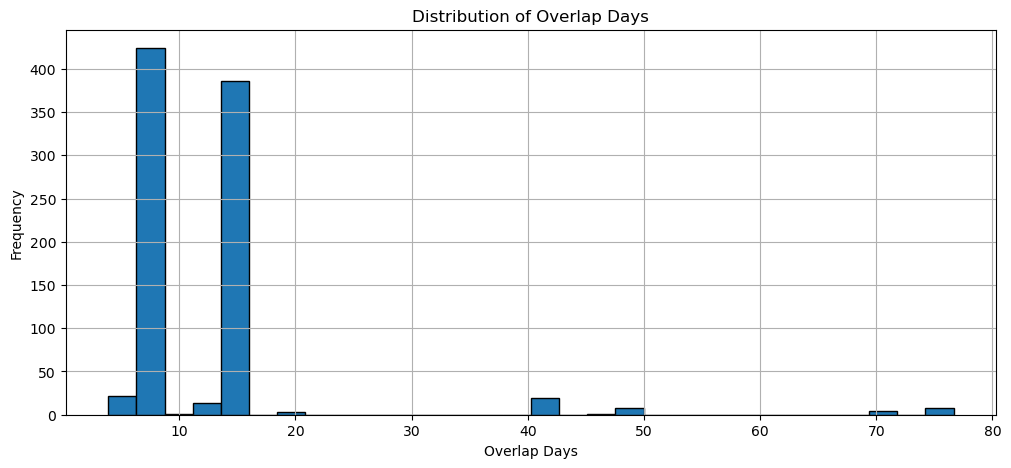

count    890.000000
mean      11.842056
std       10.058564
min        3.884722
25%        6.657639
50%        6.659722
75%       13.656944
max       76.659028
Name: overlap_days, dtype: float64

In [55]:
import matplotlib.pyplot as plt

triplets_df['overlap_days'] = (triplets_df['overlap_end'] - triplets_df['overlap_start']).dt.total_seconds() / (24 * 3600)

plt.figure(figsize=(12, 5))
triplets_df['overlap_days'].hist(bins=30, edgecolor='black')
plt.xlabel('Overlap Days')
plt.ylabel('Frequency')
plt.title('Distribution of Overlap Days')
plt.show()

display(triplets_df['overlap_days'].describe())

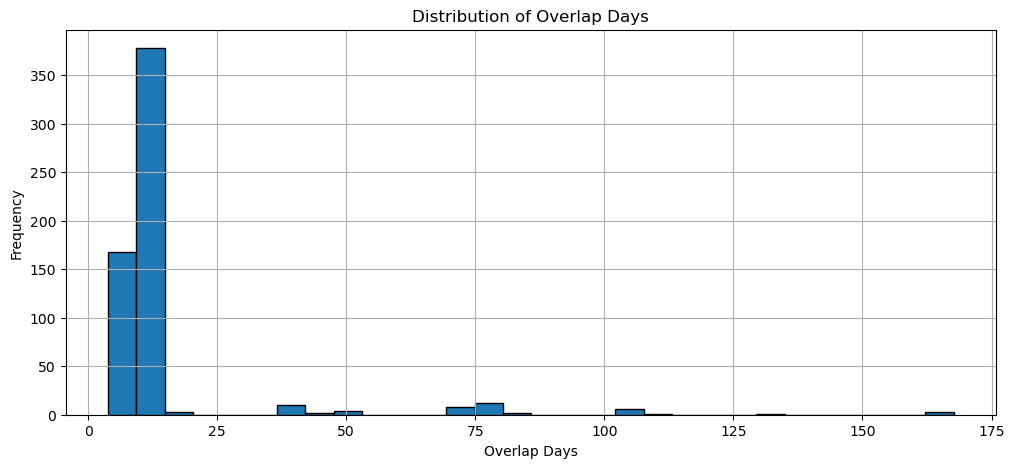

count    598.000000
mean      16.735872
std       20.249317
min        3.884722
25%        6.659722
50%       13.656250
75%       13.659722
max      167.655556
Name: overlap_days, dtype: float64

In [56]:
import matplotlib.pyplot as plt

pairs_df['overlap_days'] = (pairs_df['overlap_end'] - pairs_df['overlap_start']).dt.total_seconds() / (24 * 3600)

plt.figure(figsize=(12, 5))
pairs_df['overlap_days'].hist(bins=30, edgecolor='black')
plt.xlabel('Overlap Days')
plt.ylabel('Frequency')
plt.title('Distribution of Overlap Days')
plt.show()

display(pairs_df['overlap_days'].describe())


In [57]:
liquidity_threshold = 4e6

liquid_pairs_mask = (
    pairs_df['near_contract'].map(lambda s: notional_liquidity.set_index('symbol').loc[s, 'liquidity'] > liquidity_threshold) &
    pairs_df['far_contract'].map(lambda s: notional_liquidity.set_index('symbol').loc[s, 'liquidity'] > liquidity_threshold)
)
liquid_pairs_df = pairs_df[liquid_pairs_mask].reset_index(drop=True)

liquid_triplets_mask = (
    triplets_df['tenor1_contract'].map(lambda s: notional_liquidity.set_index('symbol').loc[s, 'liquidity'] > liquidity_threshold) &
    triplets_df['tenor2_contract'].map(lambda s: notional_liquidity.set_index('symbol').loc[s, 'liquidity'] > liquidity_threshold) &
    triplets_df['tenor3_contract'].map(lambda s: notional_liquidity.set_index('symbol').loc[s, 'liquidity'] > liquidity_threshold)
)
liquid_triplets_df = triplets_df[liquid_triplets_mask].reset_index(drop=True)

In [58]:
len(liquid_triplets_df), len(liquid_pairs_df)

(47, 50)

In [59]:
liquid_triplets_df.head()

tenor1_contract  tenor2_contract  tenor3_contract tenor1_expiry  \
0  BTC-USDT-220107  BTC-USDT-220114  BTC-USDT-220325    2022-01-07   
1  BTC-USDT-220107  BTC-USDT-220114  BTC-USDT-220624    2022-01-07   
2  BTC-USDT-220107  BTC-USDT-220325  BTC-USDT-220624    2022-01-07   
3  BTC-USDT-220114  BTC-USDT-220121  BTC-USDT-220325    2022-01-14   
4  BTC-USDT-220114  BTC-USDT-220121  BTC-USDT-220624    2022-01-14   

  tenor2_expiry tenor3_expiry       overlap_start overlap_end  overlap_days  
0    2022-01-14    2022-03-25 2021-12-31 16:00:00  2022-01-07      6.333333  
1    2022-01-14    2022-06-24 2021-12-31 16:00:00  2022-01-07      6.333333  
2    2022-03-25    2022-06-24 2021-12-31 16:00:00  2022-01-07      6.333333  
3    2022-01-21    2022-03-25 2022-01-07 08:10:00  2022-01-14      6.659722  
4    2022-01-21    2022-06-24 2022-01-07 08:10:00  2022-01-14      6.659722

In [60]:
liquid_triplet_set = set(
    tuple(row) for row in liquid_triplets_df[['tenor1_contract', 'tenor2_contract', 'tenor3_contract']].values
)

filtered_butterfly_triplets = butterfly_triplets[
    butterfly_triplets.apply(
        lambda row: (row['tenor1_contract'], row['tenor2_contract'], row['tenor3_contract']) in liquid_triplet_set,
        axis=1
    )
].reset_index(drop=True)

In [61]:
filtered_butterfly_triplets['timestamp'] = pd.to_datetime(filtered_butterfly_triplets['timestamp'])

expiry_map = {}
for _, row in liquid_triplets_df.iterrows():
    expiry_map[row['tenor1_contract']] = row['tenor1_expiry']
    expiry_map[row['tenor2_contract']] = row['tenor2_expiry']
    expiry_map[row['tenor3_contract']] = row['tenor3_expiry']

for tenor in ['tenor1', 'tenor2', 'tenor3']:
    contract_col = f'{tenor}_contract'
    expiry_col = f'{tenor}_expiry'
    min_to_exp_col = f'{tenor}_min_to_exp'
    filtered_butterfly_triplets[min_to_exp_col] = (
        filtered_butterfly_triplets.apply(
            lambda row: (expiry_map[row[contract_col]] - row['timestamp']).total_seconds() / 60,
            axis=1
        )
    )

In [62]:
filtered_butterfly_triplets.head()

timestamp   close1   close2   close3  tenor1_contract  \
0 2021-12-31 16:00:00  47952.9  48006.6  48970.1  BTC-USDT-220107   
1 2021-12-31 16:01:00  47899.2  47952.8  48937.3  BTC-USDT-220107   
2 2021-12-31 16:02:00  47916.5  47963.2  48953.4  BTC-USDT-220107   
3 2021-12-31 16:03:00  47902.0  47938.7  48926.2  BTC-USDT-220107   
4 2021-12-31 16:04:00  47906.2  47943.0  48930.7  BTC-USDT-220107   

   tenor2_contract  tenor3_contract  tenor1_min_to_exp  tenor2_min_to_exp  \
0  BTC-USDT-220114  BTC-USDT-220325             9120.0            19200.0   
1  BTC-USDT-220114  BTC-USDT-220325             9119.0            19199.0   
2  BTC-USDT-220114  BTC-USDT-220325             9118.0            19198.0   
3  BTC-USDT-220114  BTC-USDT-220325             9117.0            19197.0   
4  BTC-USDT-220114  BTC-USDT-220325             9116.0            19196.0   

   tenor3_min_to_exp  
0           120000.0  
1           119999.0  
2           119998.0  
3           119997.0  
4           119996.0

### Butterfly Spread Analysis
- **Contract Selection**: Filters liquid futures contracts (>4M notional liquidity threshold) and identifies valid triplets with overlapping time periods
- **Time-to-Expiry Calculations**: Computes minutes to expiry for each contract in the triplet to enable dynamic weight adjustments
- **Butterfly Construction**: Creates level- and slope-neutral butterfly spreads using dynamic weights based on time-to-expiry ratios
- **Statistical Processing**: Applies rolling median absolute deviation (MAD) to compute robust z-scores for butterfly values
- **Visualization**: Generates time series plots of butterfly z-scores with ±2 standard deviation bands for mean reversion signals


In [63]:
butterfly_zcored = pd.DataFrame()

for idx, row in liquid_triplets_df.iterrows():
    t1, t2, t3 = row['tenor1_contract'], row['tenor2_contract'], row['tenor3_contract']

    triplet_df = filtered_butterfly_triplets[
        (filtered_butterfly_triplets['tenor1_contract'] == t1) &
        (filtered_butterfly_triplets['tenor2_contract'] == t2) &
        (filtered_butterfly_triplets['tenor3_contract'] == t3)
    ].copy() 

    triplet_df['tau1'] = triplet_df['tenor1_min_to_exp']
    triplet_df['tau2'] = triplet_df['tenor2_min_to_exp'] 
    triplet_df['tau3'] = triplet_df['tenor3_min_to_exp']

    triplet_df['w1'] = 1.0
    triplet_df['w3'] = 1.0
    
    triplet_df['w2'] = -(triplet_df['w1'] * triplet_df['tau1'] + triplet_df['w3'] * triplet_df['tau3']) / triplet_df['tau2']

    triplet_df['fly_value'] = (triplet_df['w1'] * triplet_df['close1'] + 
                               triplet_df['w2'] * triplet_df['close2'] + 
                               triplet_df['w3'] * triplet_df['close3'])
    
    rolling_median = triplet_df['fly_value'].rolling(window=30, min_periods=10).median()
    rolling_mad = triplet_df['fly_value'].rolling(window=30, min_periods=10).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    mad_scaled = rolling_mad * 1.4826  
    
    triplet_df['fly_value_zscore'] = (triplet_df['fly_value'] - rolling_median) / mad_scaled
    
    butterfly_zcored = pd.concat([butterfly_zcored, triplet_df], ignore_index=True)


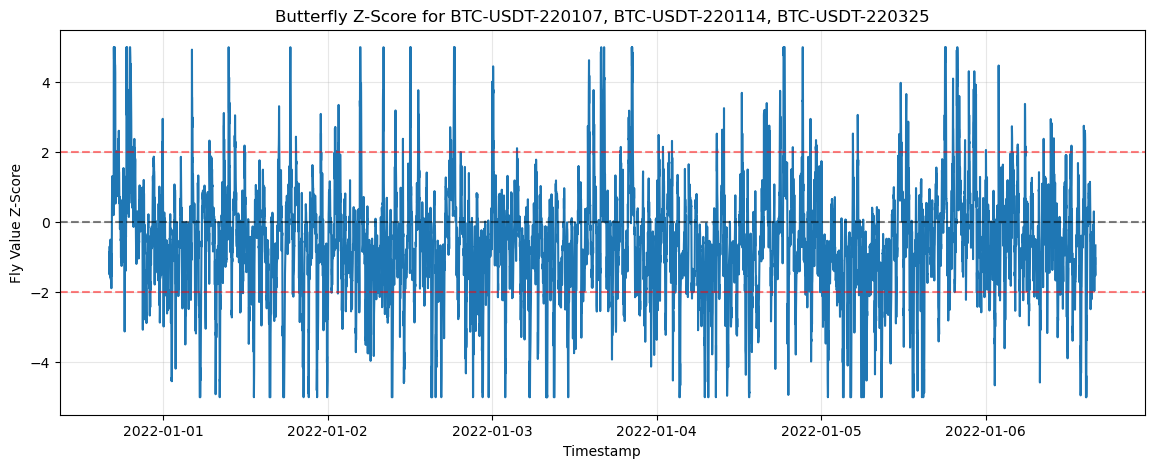

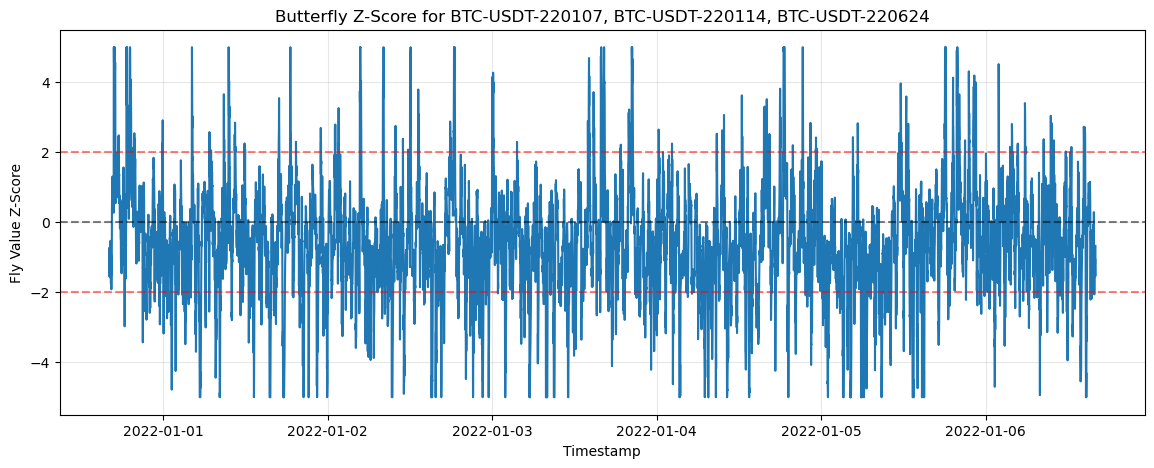

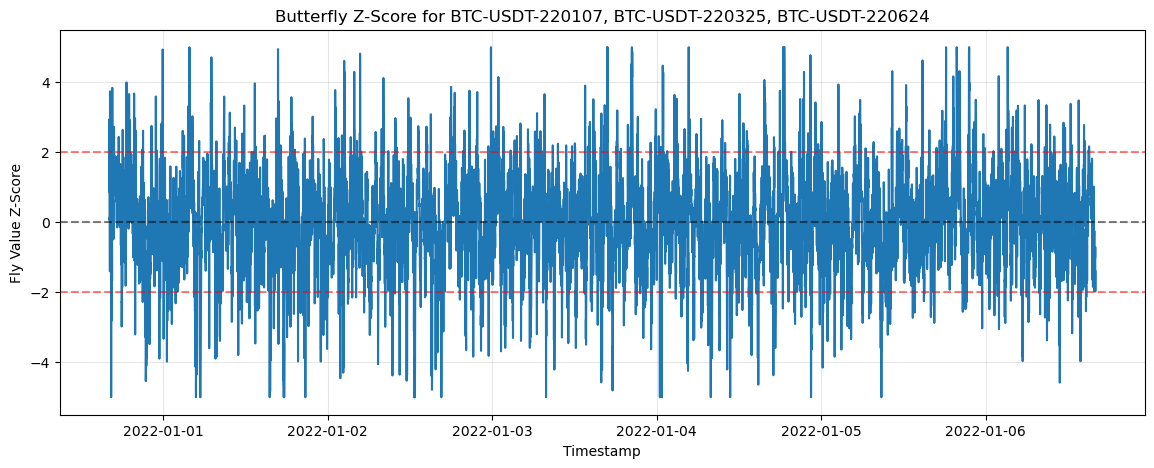

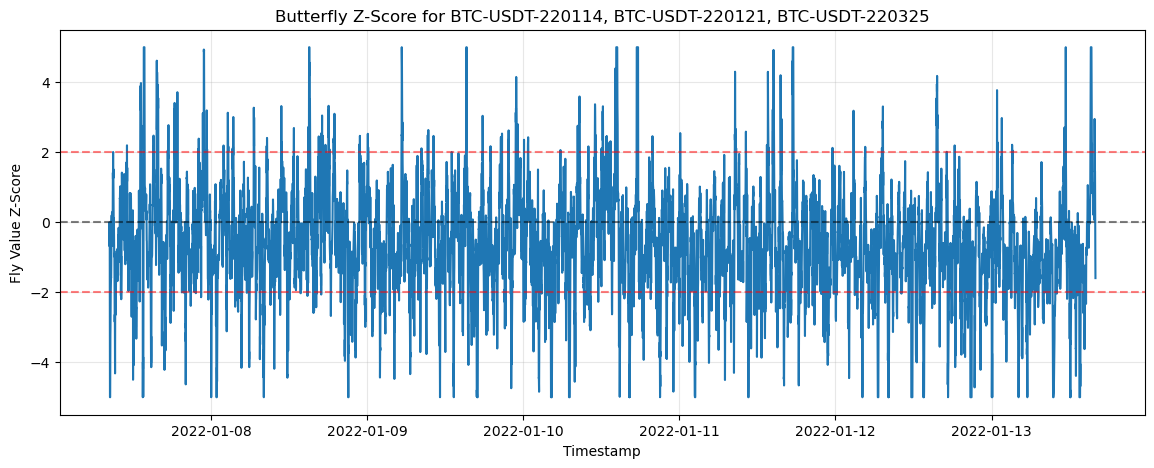

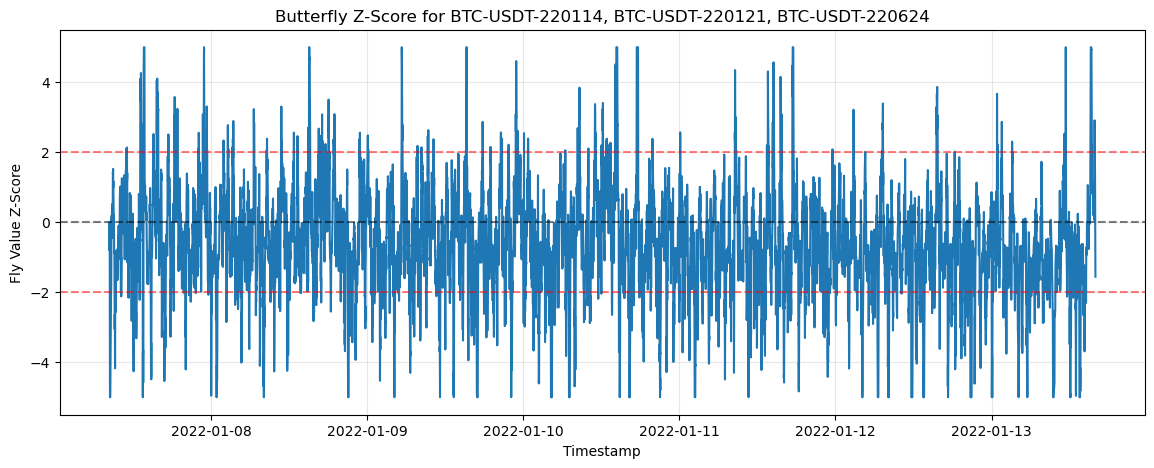

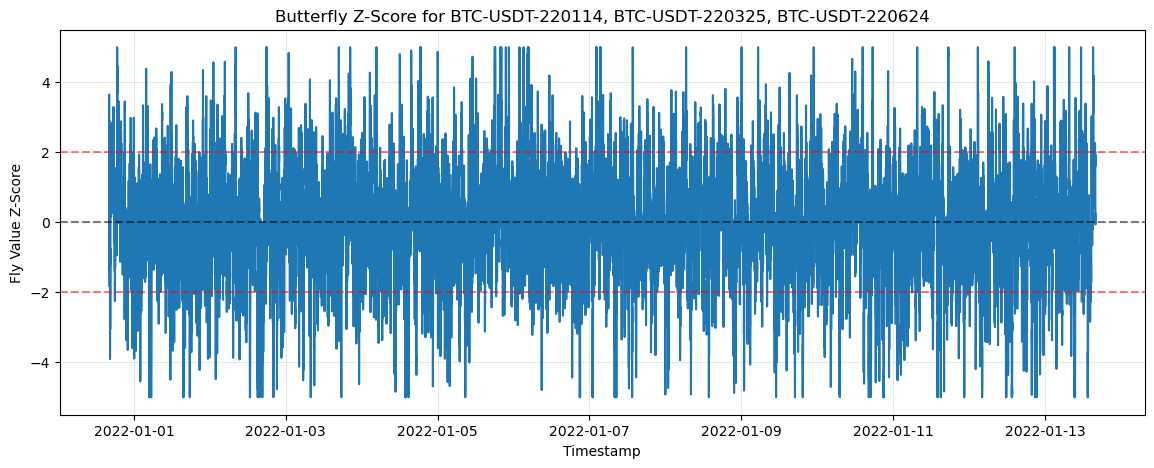

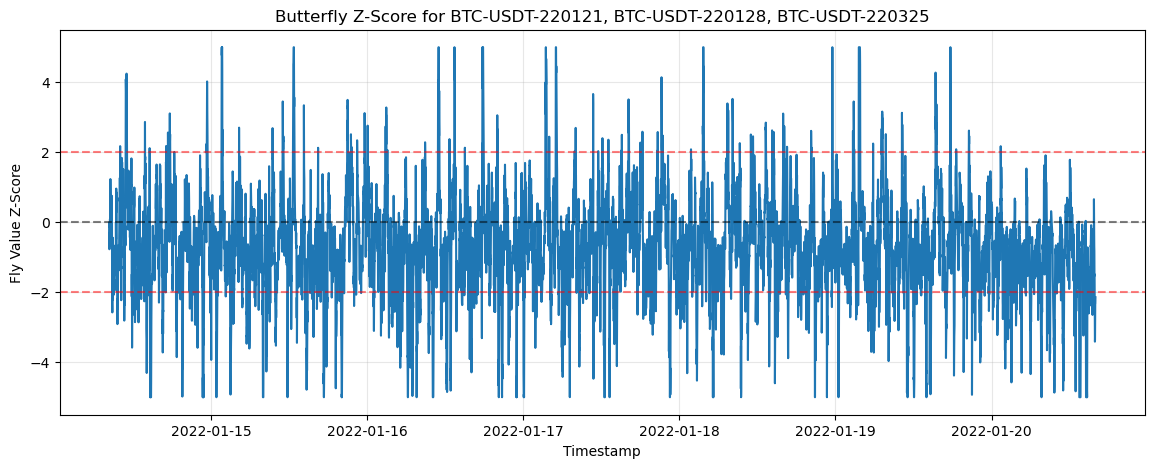

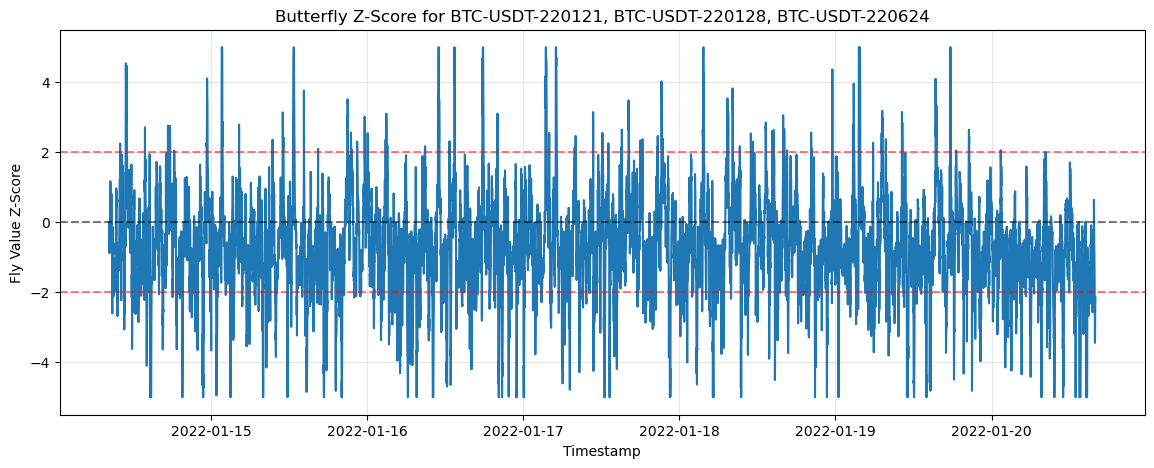

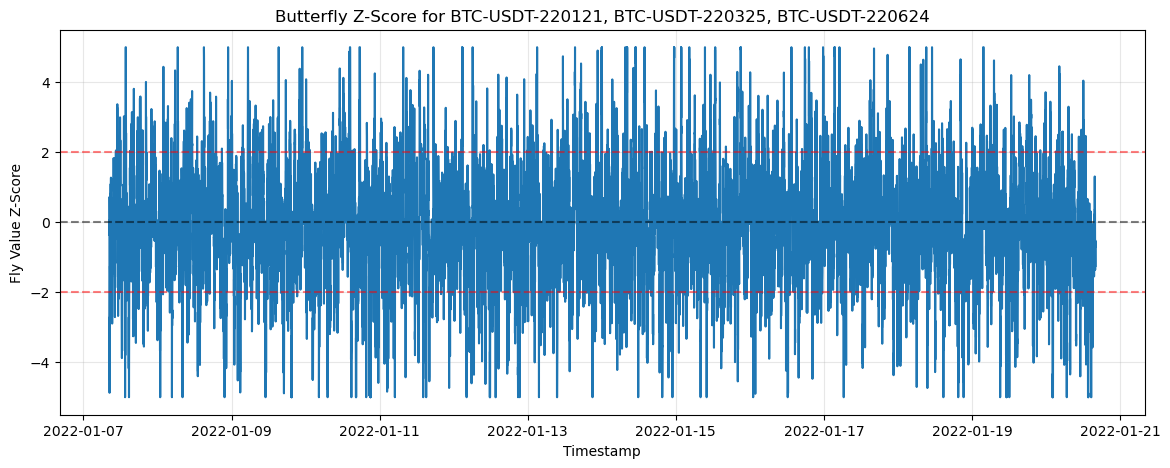

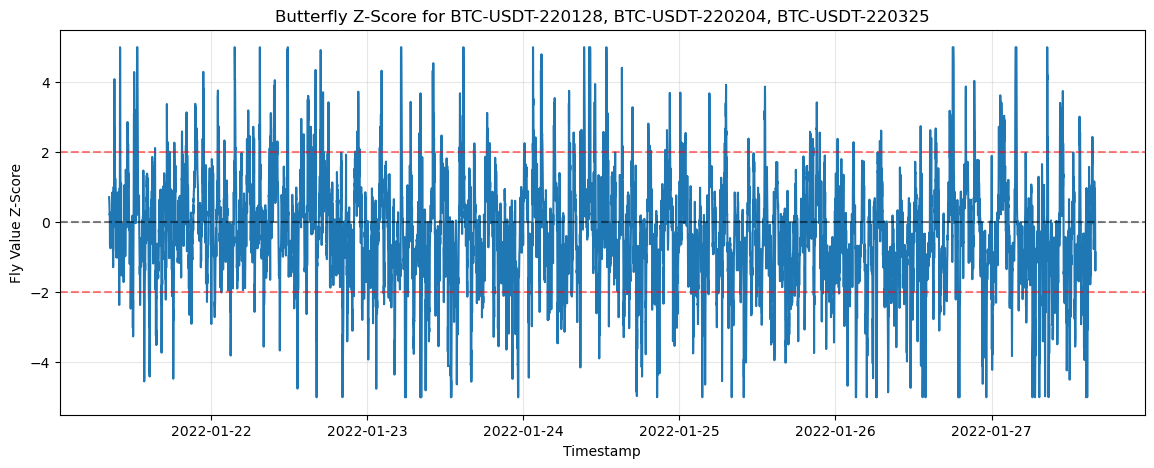

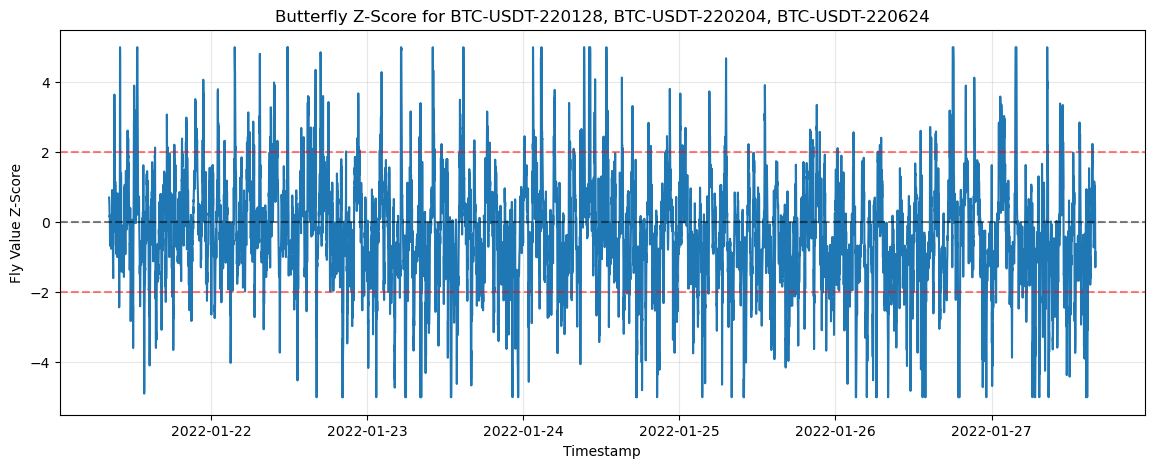

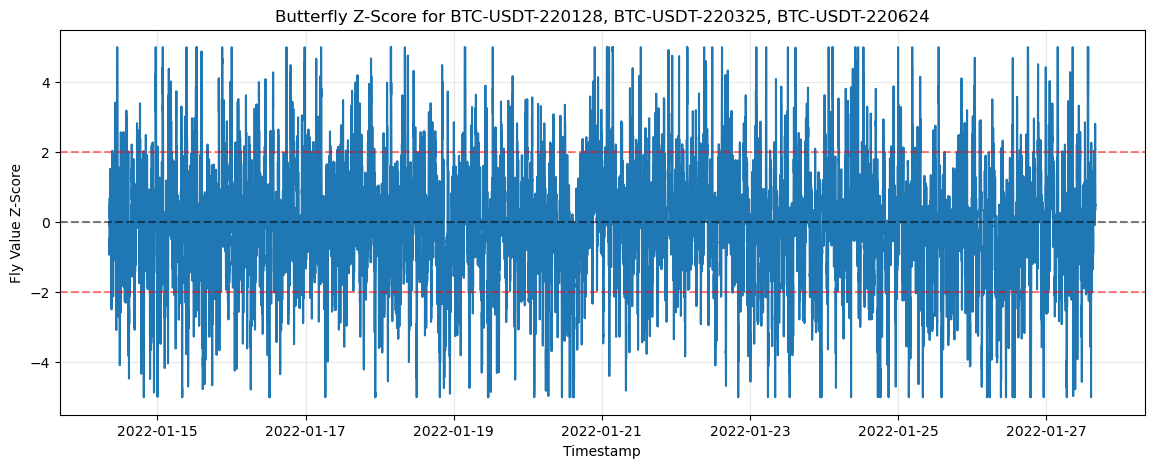

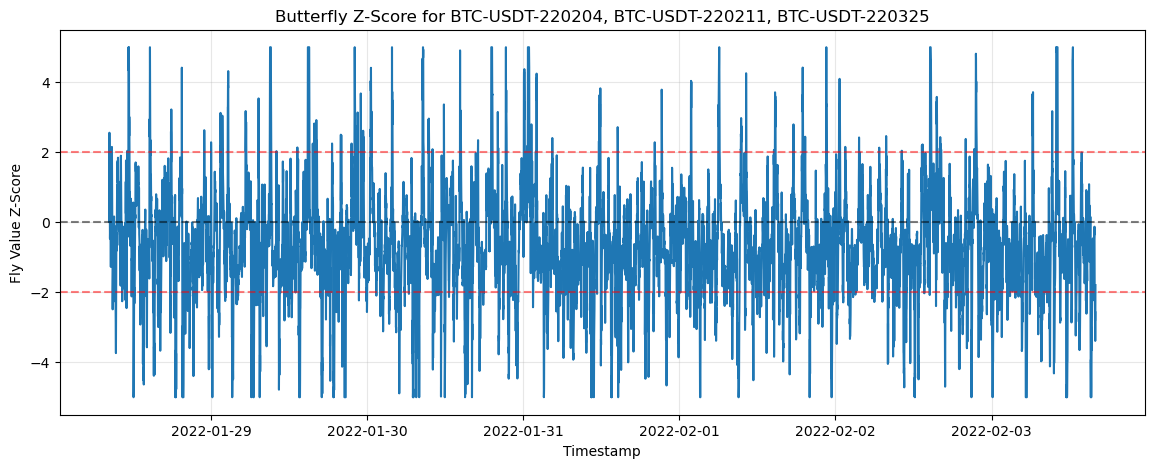

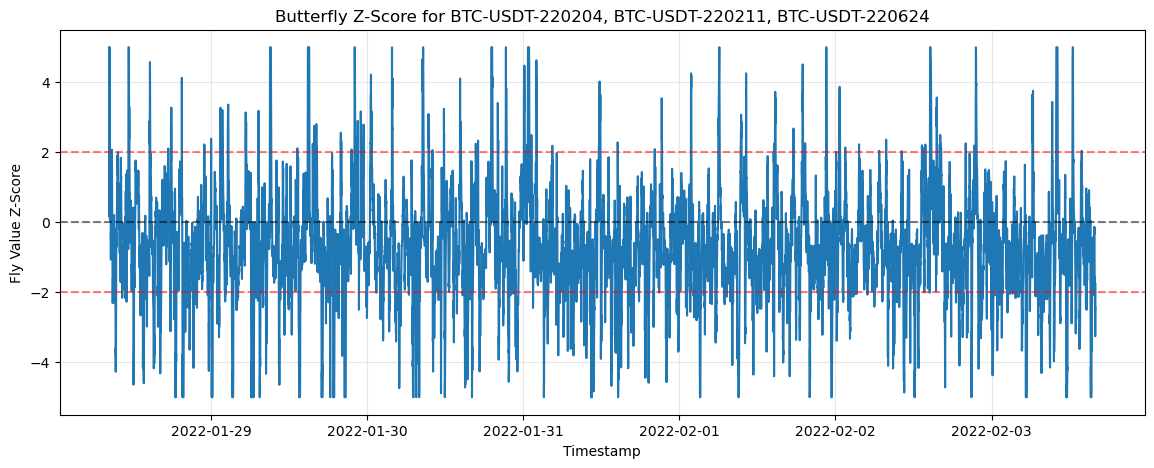

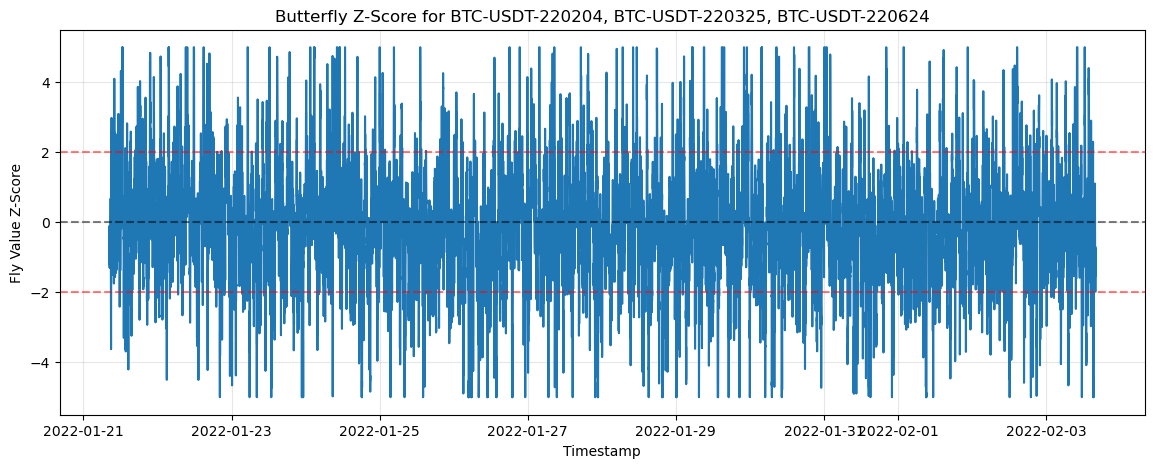

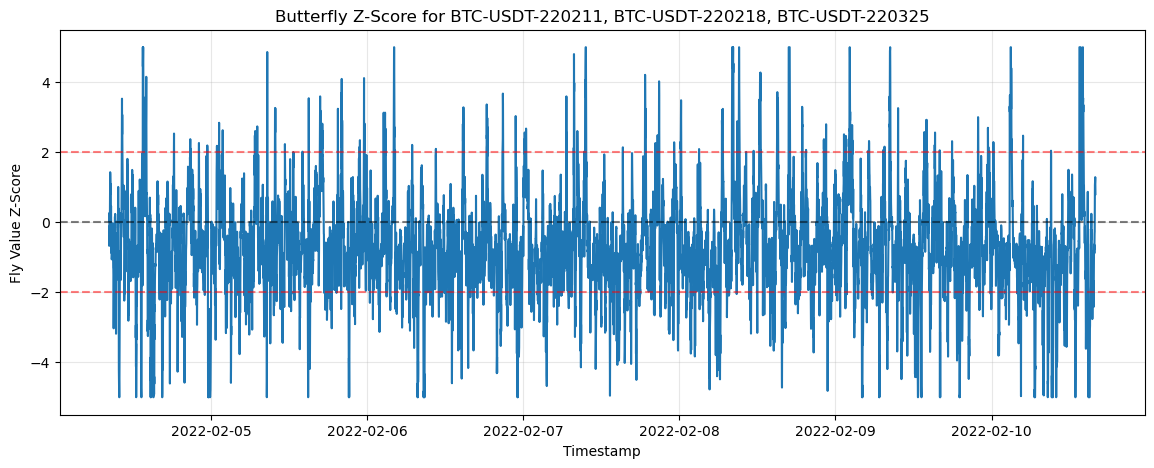

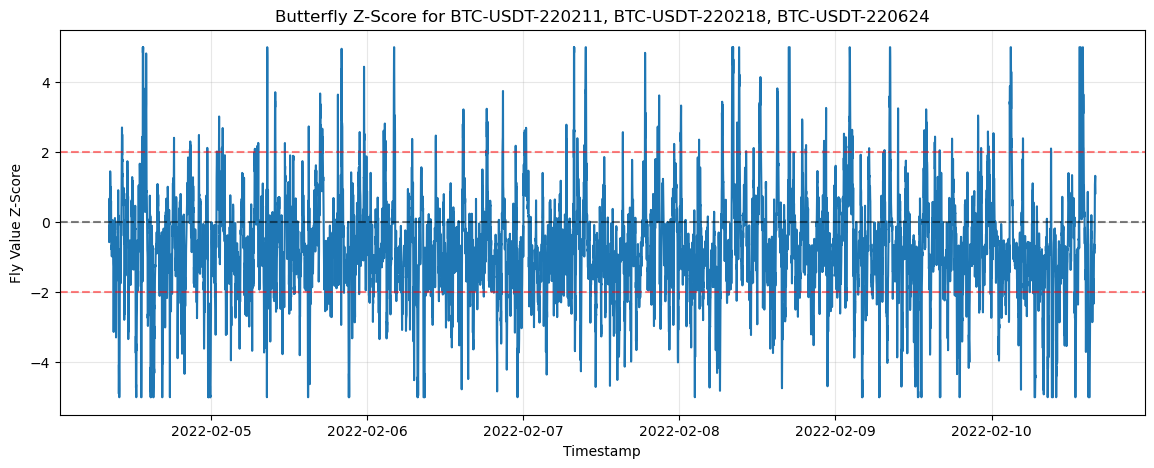

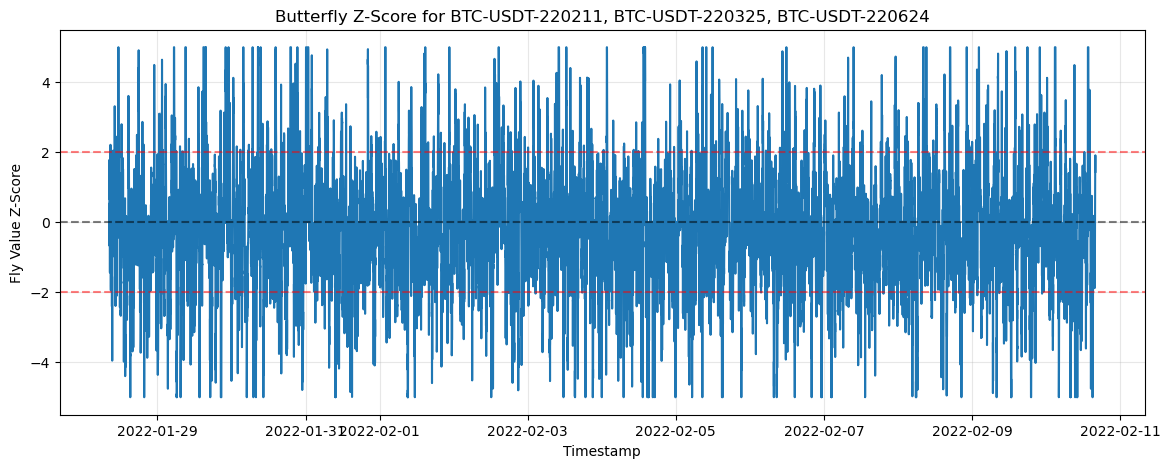

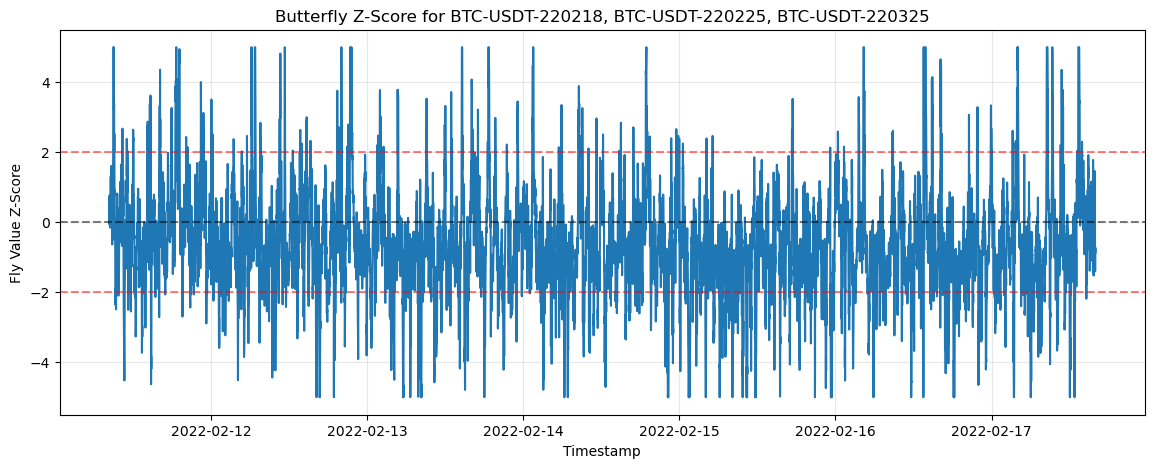

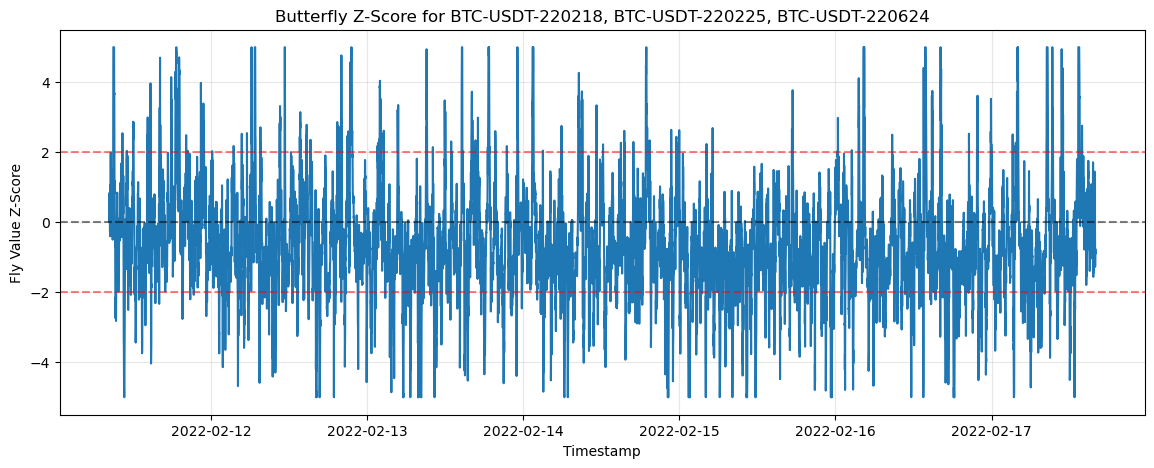

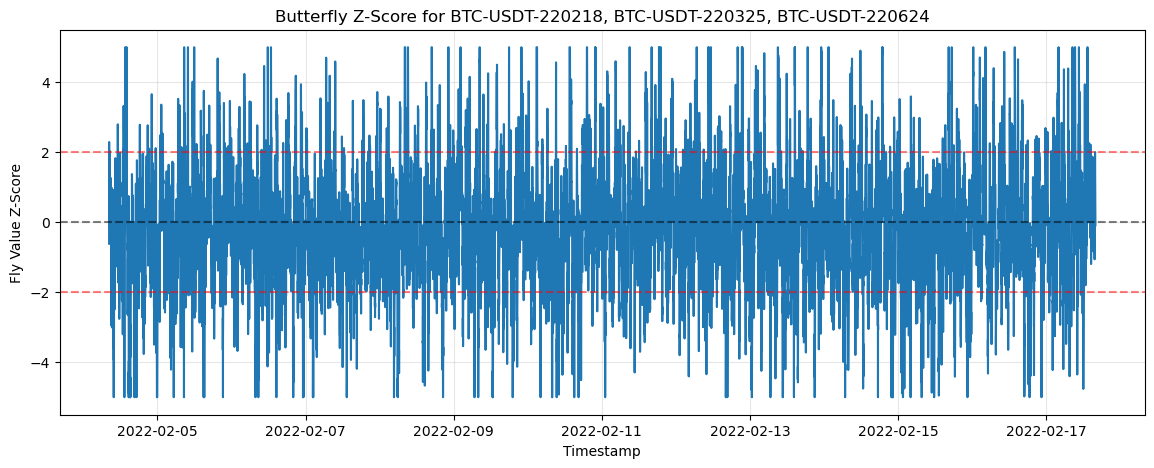

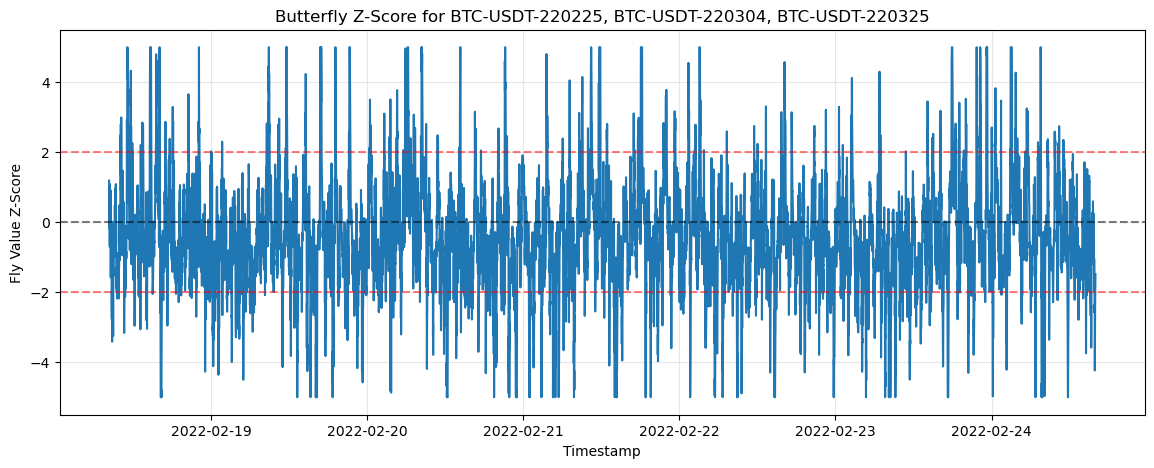

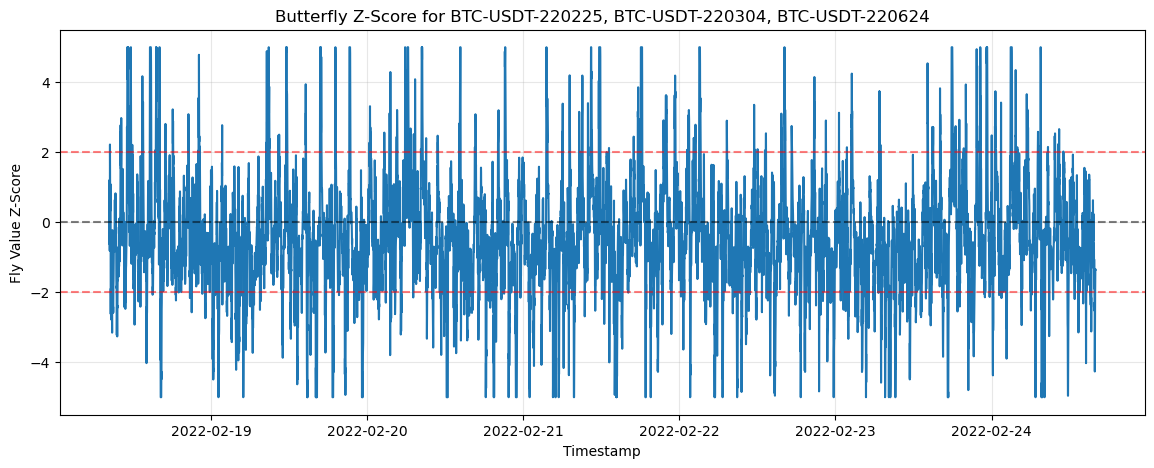

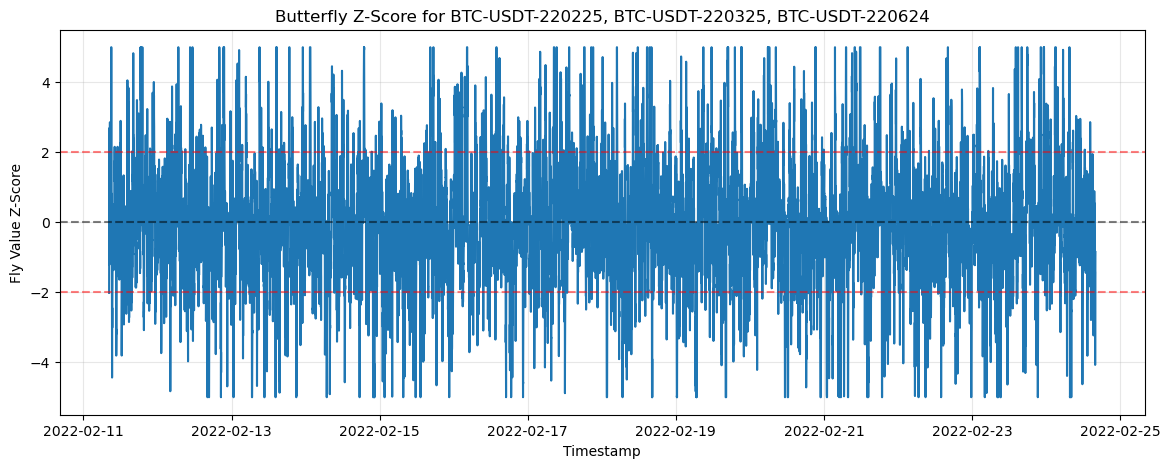

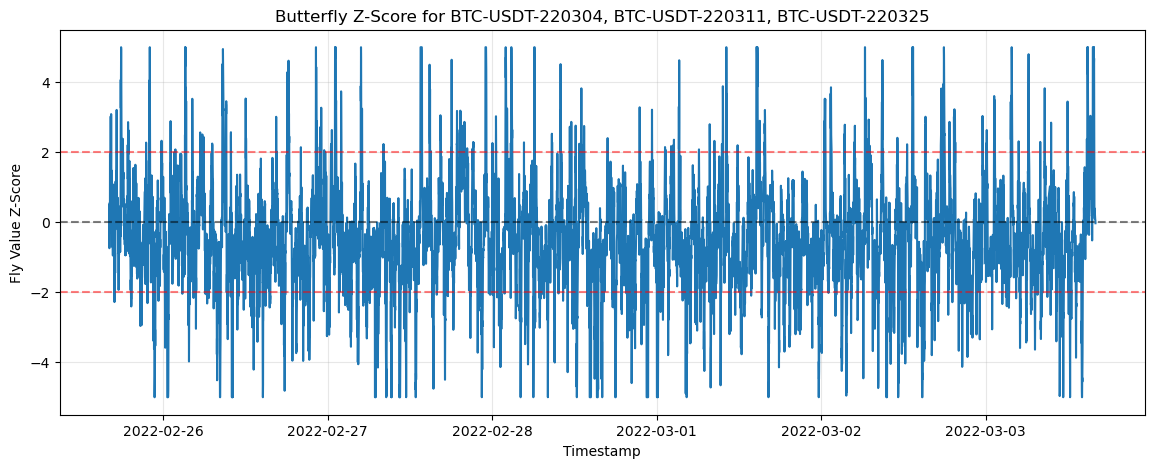

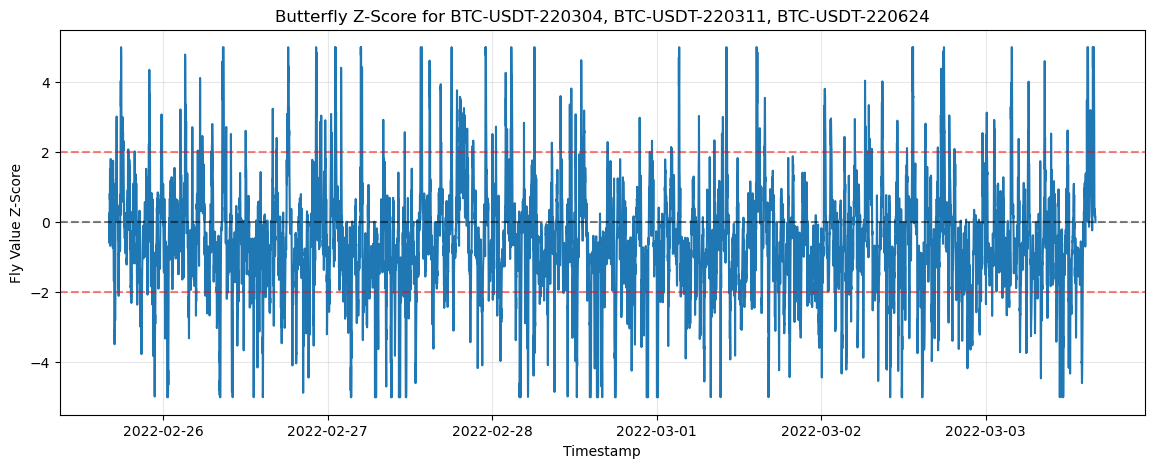

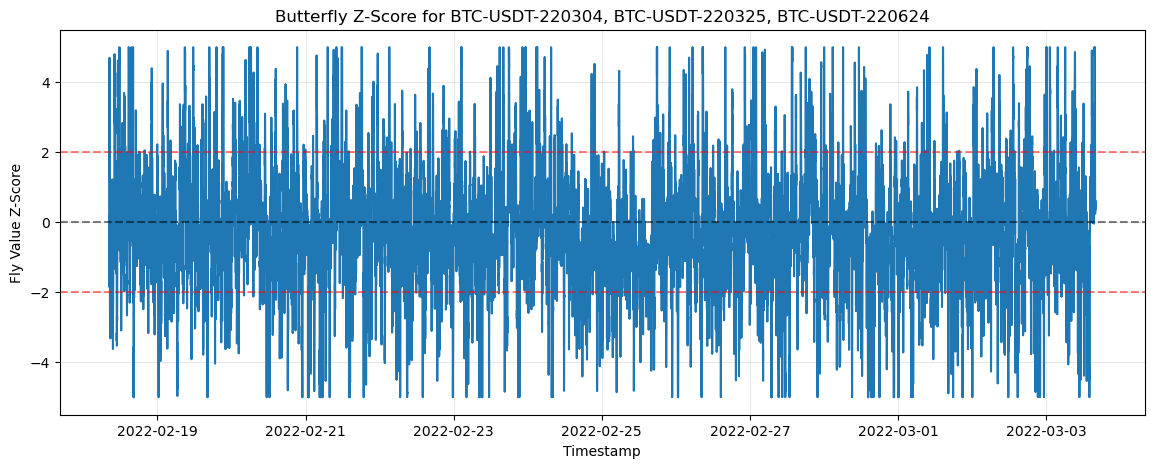

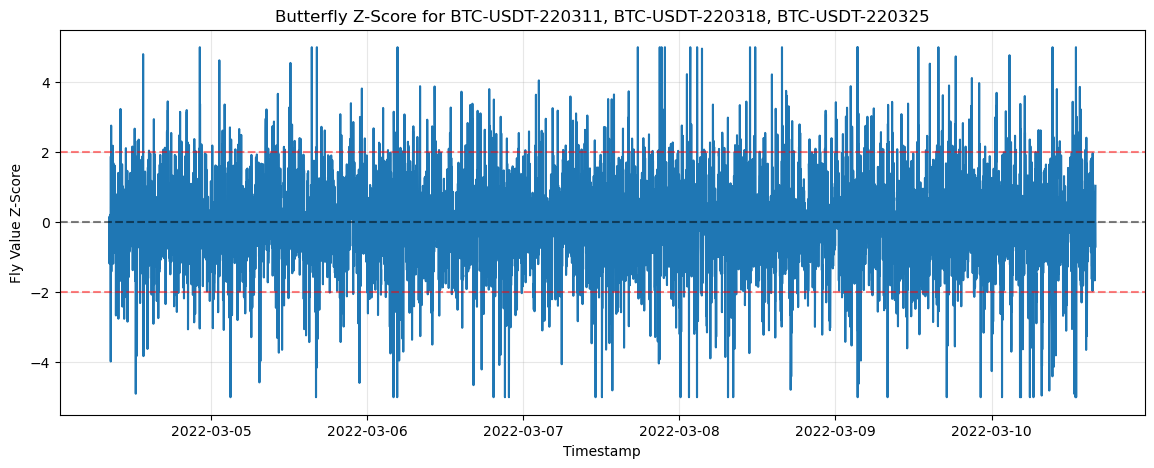

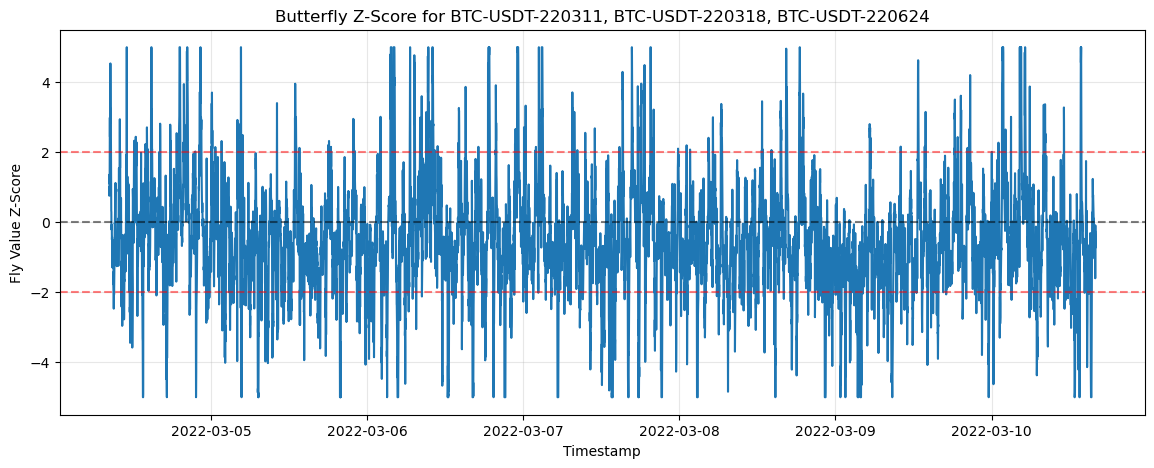

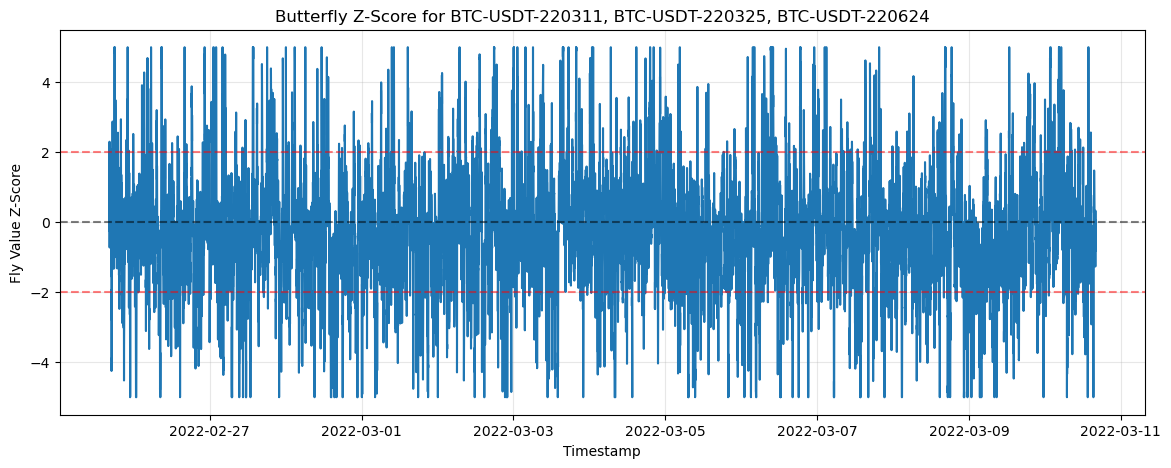

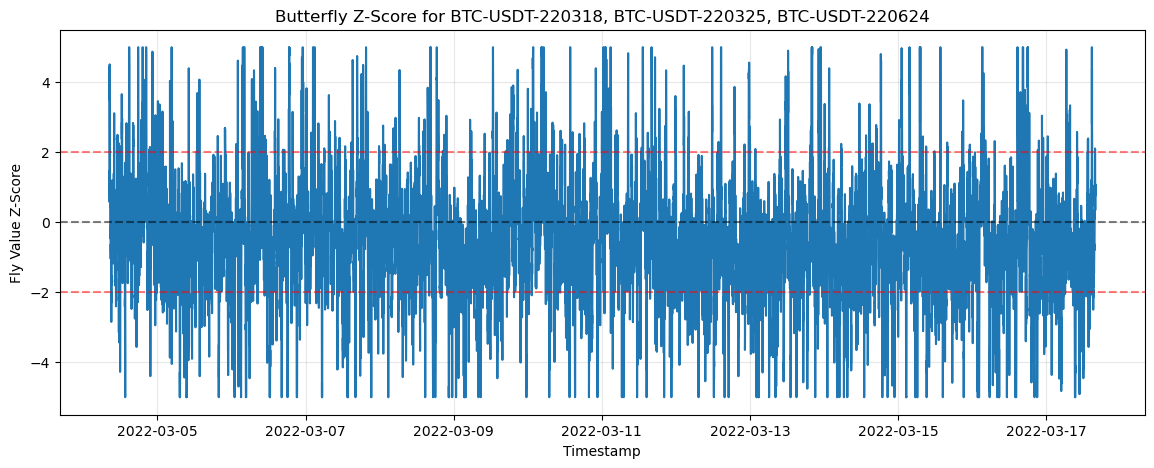

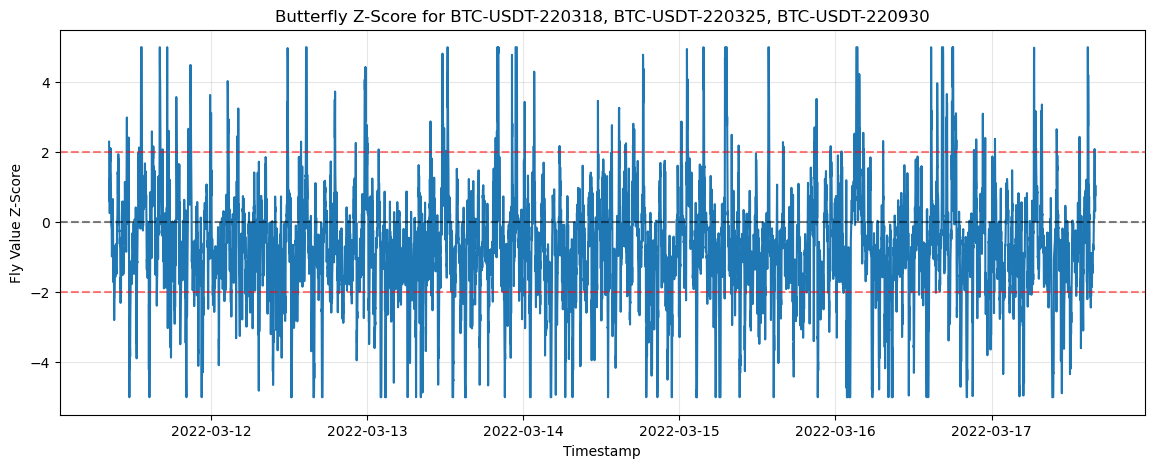

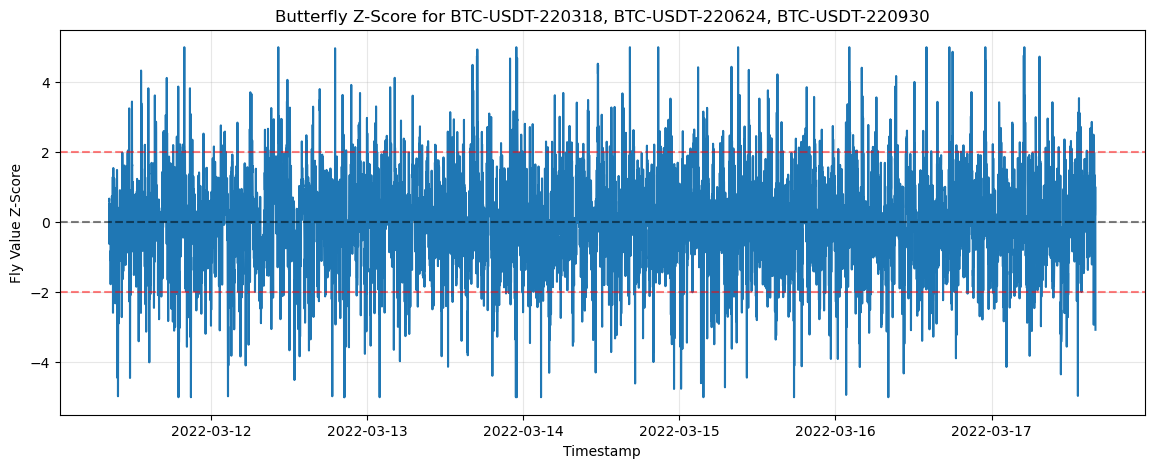

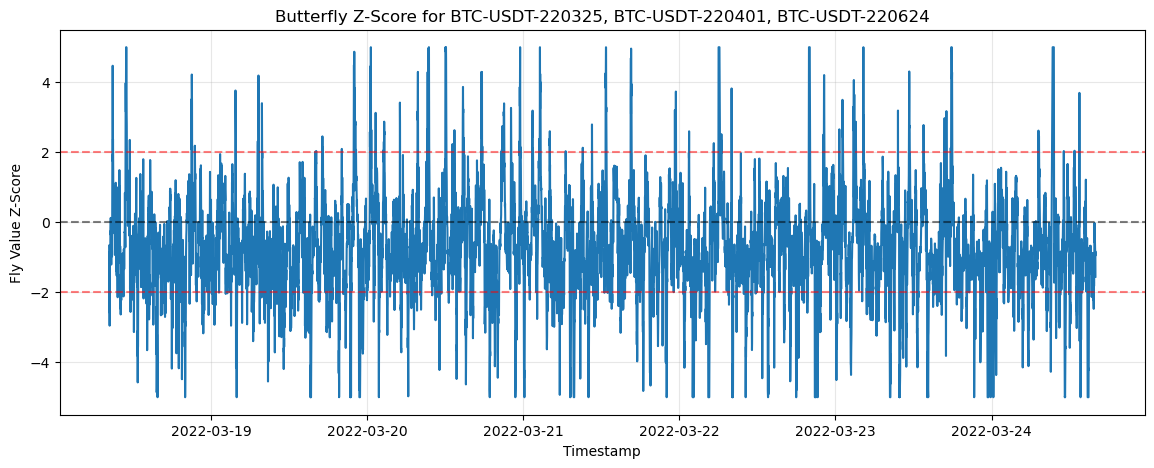

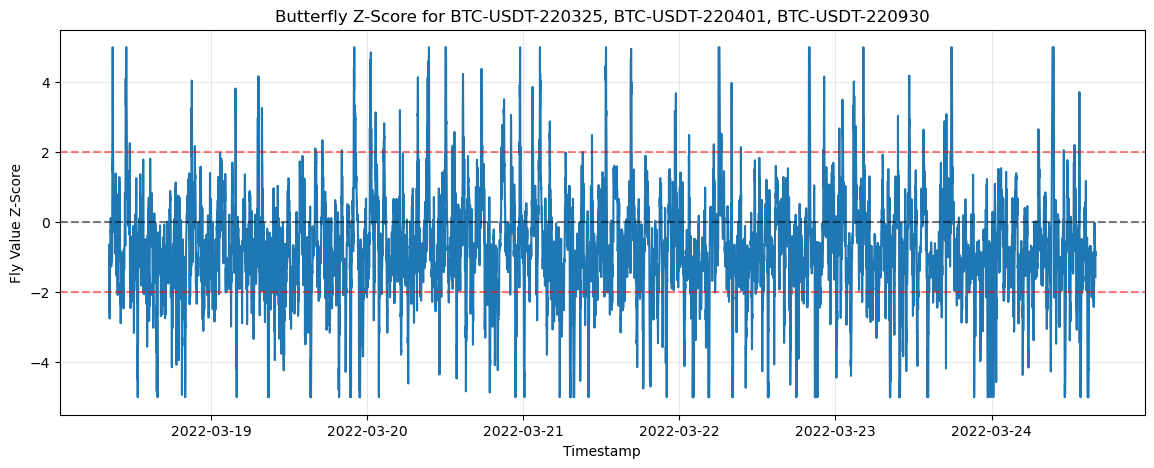

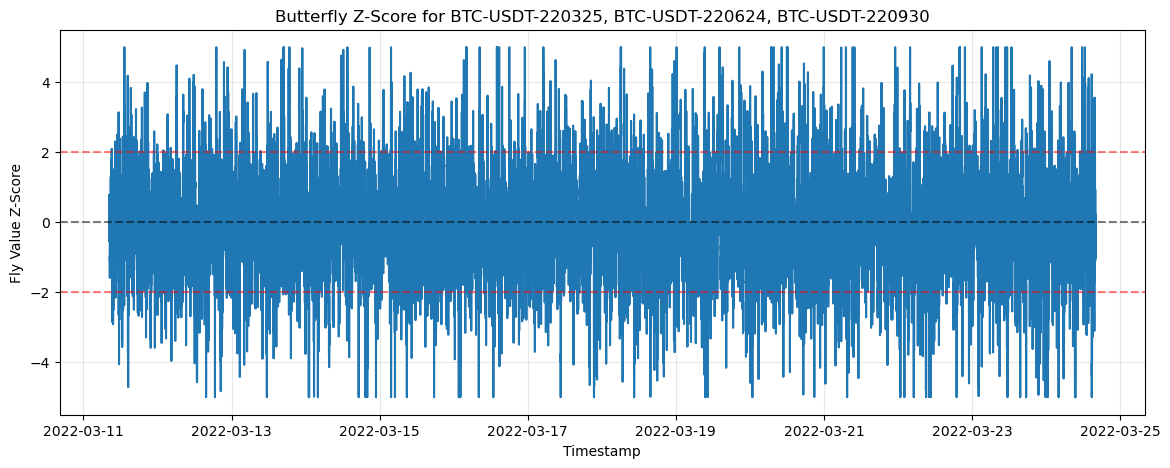

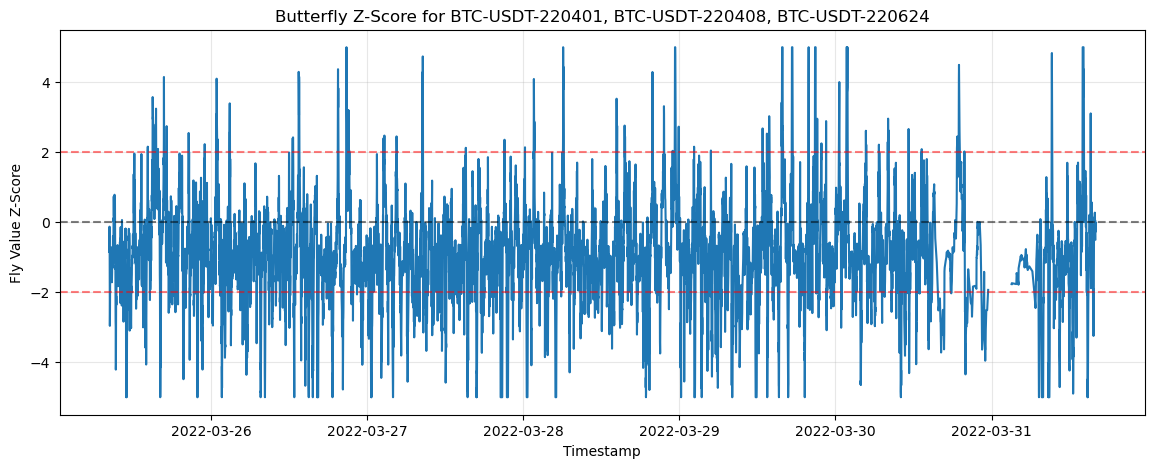

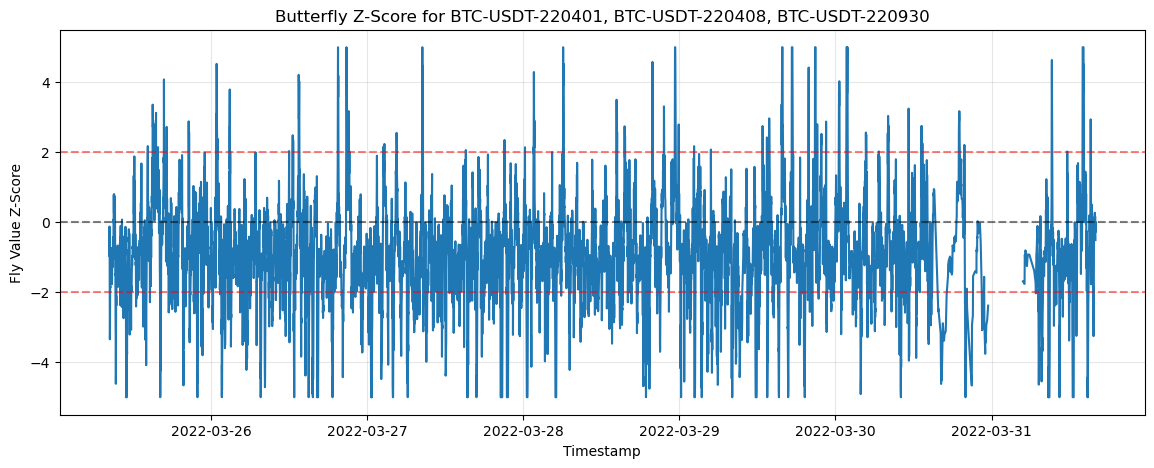

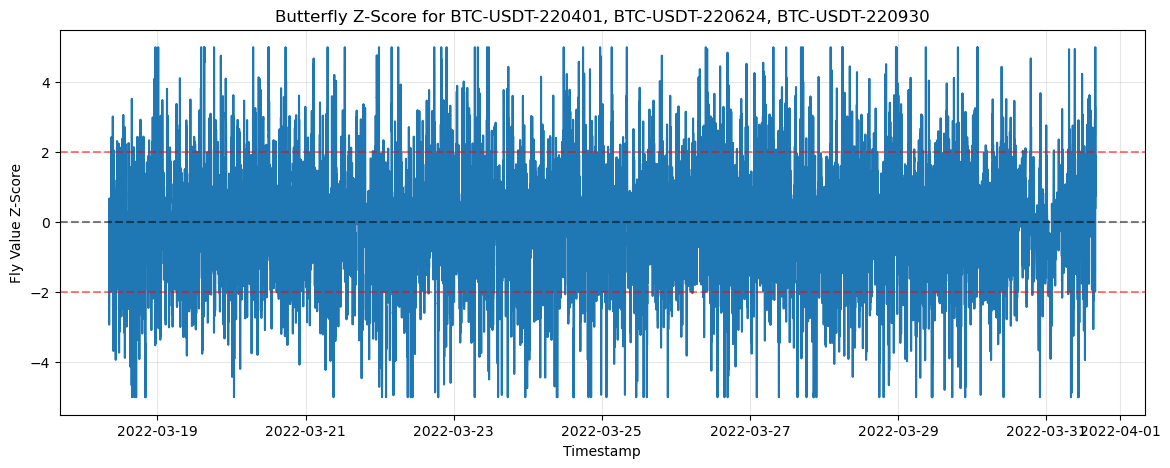

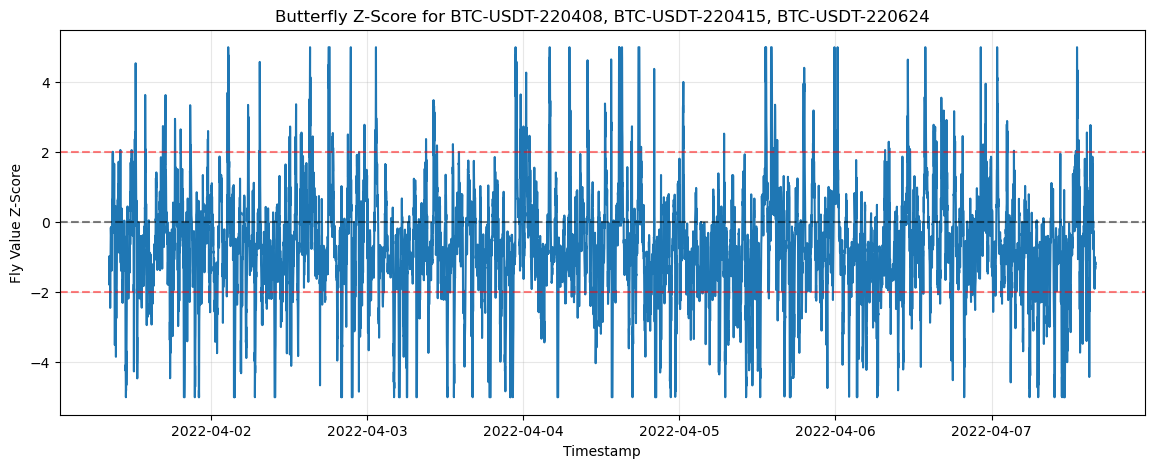

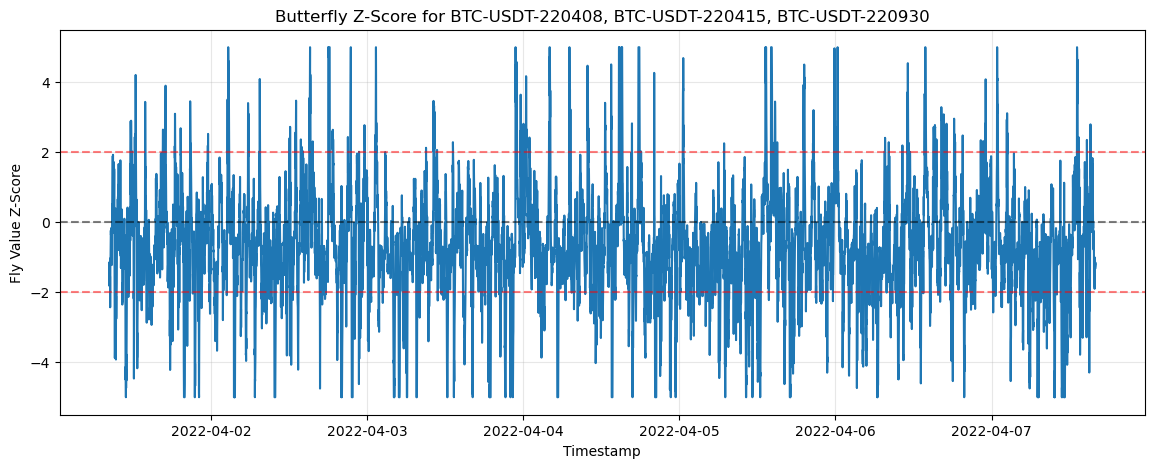

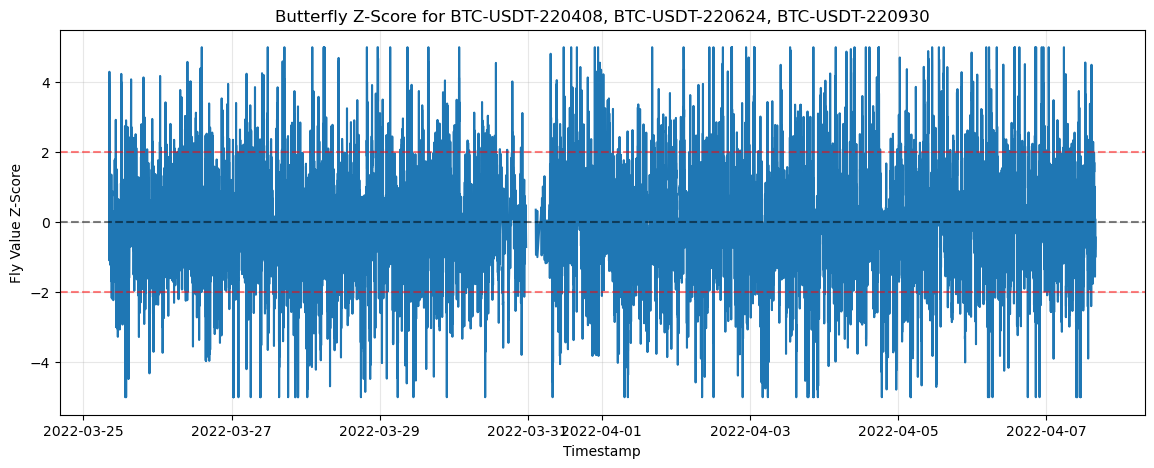

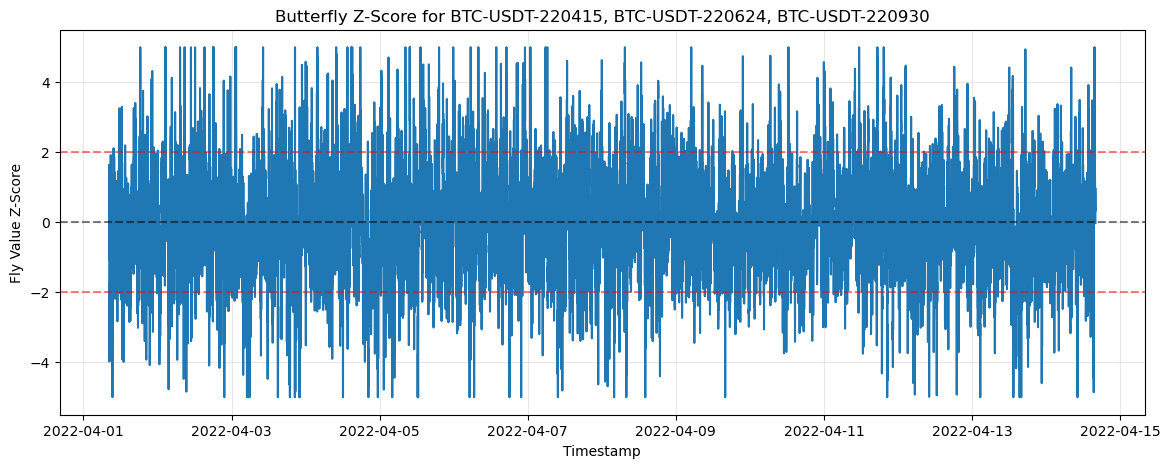

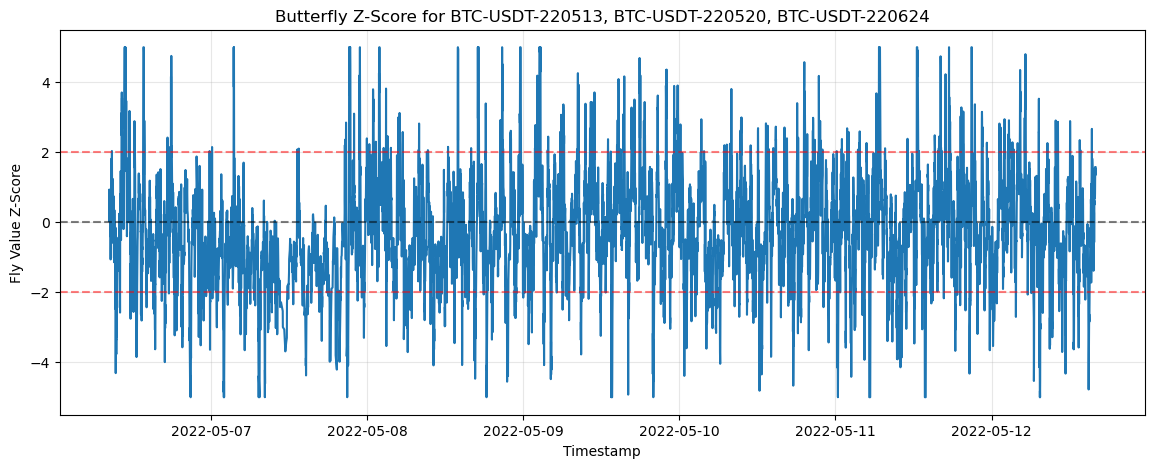

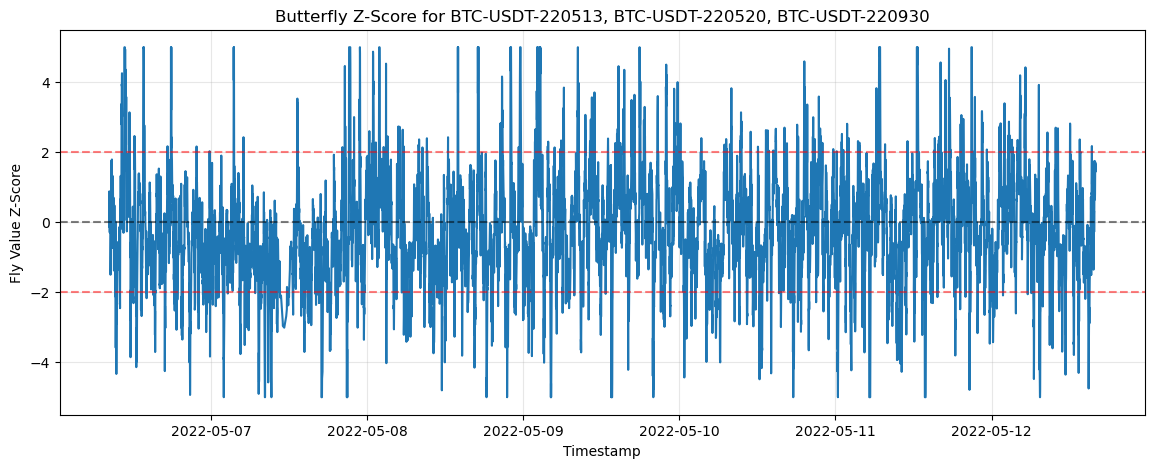

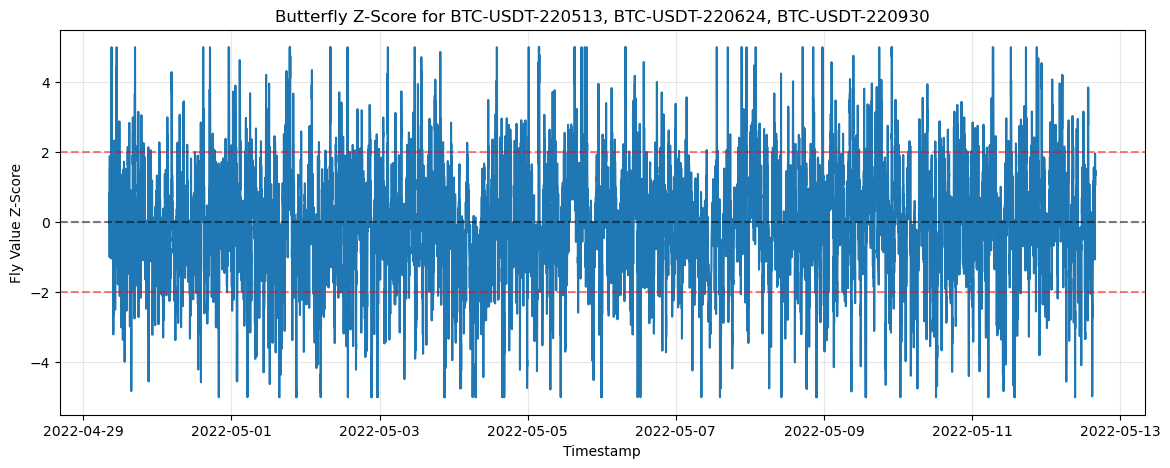

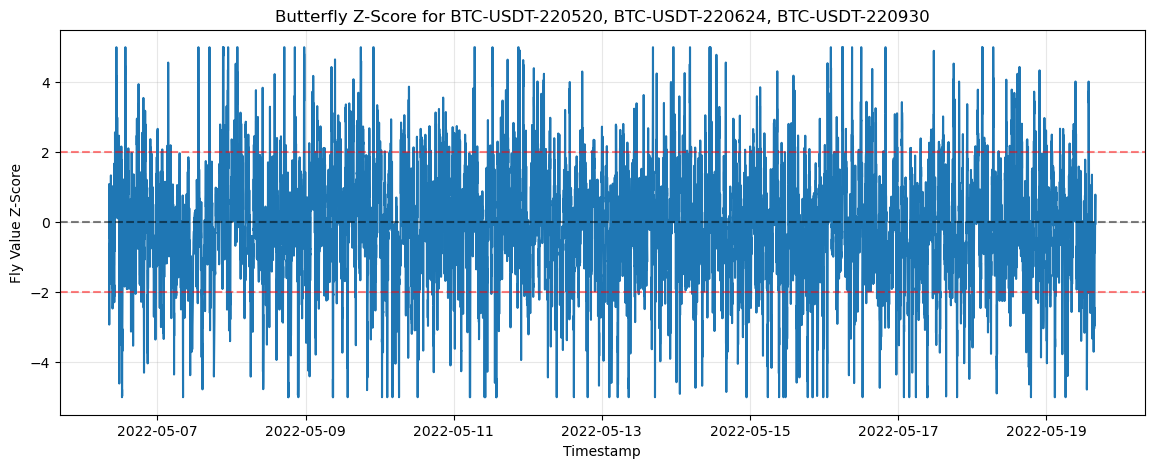

In [64]:
for idx, row in liquid_triplets_df.iterrows():
    t1, t2, t3 = row['tenor1_contract'], row['tenor2_contract'], row['tenor3_contract']

    triplet_df = butterfly_zcored[
        (butterfly_zcored['tenor1_contract'] == t1) &
        (butterfly_zcored['tenor2_contract'] == t2) &
        (butterfly_zcored['tenor3_contract'] == t3)
    ].copy()

    triplet_df['fly_value_zscore'] = triplet_df['fly_value_zscore'].clip(-5, 5)

    if len(triplet_df) > 0:
        plt.figure(figsize=(14, 5))
        plt.plot(triplet_df['timestamp'], triplet_df['fly_value_zscore'])
        plt.title(f"Butterfly Z-Score for {t1}, {t2}, {t3}")
        plt.xlabel("Timestamp")
        plt.ylabel("Fly Value Z-Score")
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.axhline(y=2, color='red', linestyle='--', alpha=0.5)
        plt.axhline(y=-2, color='red', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3)
        plt.show()

In [39]:
liquid_triplets_df.to_csv('../data/liquid_triplets_series_flat.csv', index=False)

butterfly_zcored.to_csv('../data/butterfly_zcored.csv', index=False)

### Calendar Spread Construction Summary
- **Cointegration Testing**: Estimates hedge ratios between near and far contract pairs using OLS regression
- **Rolling Beta Calculation**: Computes time-varying hedge ratios using 60-minute rolling windows
- **Spread Construction**: Creates multiple spread variants (simple, log, volatility-adjusted) to capture different risk characteristics
- **Stationarity Filtering**: Uses Augmented Dickey-Fuller tests and Hurst exponents to identify mean-reverting spreads
- **Z-Score Normalization**: Applies robust MAD-based z-scoring with winsorization to handle outliers
- **Data Export**: Flattens all spread series into a single CSV file for further analysis

In [65]:
import pandas as pd
import statsmodels.api as sm

def estimate_cointegration(x, y):
    y_const = sm.add_constant(y)
    model = sm.OLS(x, y_const).fit()
    beta = model.params.iloc[1] 
    spread = model.resid
    return beta, spread

In [66]:
def rolling_beta(close_far, close_near, window):
    beta_series = []
    for i in range(len(close_far)):
        if i < window:
            beta_series.append(np.nan)
            continue
        y = close_far.iloc[i-window+1:i+1]
        x = close_near.iloc[i-window+1:i+1]
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        
        beta_series.append(model.params.iloc[1])
        
    return pd.Series(beta_series, index=close_far.index)

In [ ]:
spread_series = {}

window = 60

for idx, row in liquid_pairs_df.iterrows():
    near_symbol = row['near_contract']
    far_symbol = row['far_contract']
    overlap_start = row['overlap_start']
    overlap_end = row['overlap_end']

    near_df = df[(df['symbol'] == near_symbol) & 
                 (pd.to_datetime(df['timestamp']) >= overlap_start) & 
                 (pd.to_datetime(df['timestamp']) <= overlap_end)][['timestamp', 'close', 'volume']]
    far_df = df[(df['symbol'] == far_symbol) & 
                (pd.to_datetime(df['timestamp']) >= overlap_start) & 
                (pd.to_datetime(df['timestamp']) <= overlap_end)][['timestamp', 'close', 'volume']]

    near_df = near_df.set_index(pd.to_datetime(near_df['timestamp'])).sort_index()
    far_df = far_df.set_index(pd.to_datetime(far_df['timestamp'])).sort_index()
    near_df = near_df.rename(columns={'close': 'close_near', 'volume': 'volume_near'})
    far_df = far_df.rename(columns={'close': 'close_far', 'volume': 'volume_far'})

    spread_df = near_df[['close_near', 'volume_near']].join(far_df[['close_far', 'volume_far']], how='inner')

    spread_df = spread_df.dropna()  

    beta, spread = estimate_cointegration(spread_df['close_far'], spread_df['close_near'])

    spread_df['spread'] = spread
    spread_df['log_spread'] = np.log(spread_df['close_far']) - beta * np.log(spread_df['close_near'])
    
    spread_df['beta'] = rolling_beta(spread_df['close_far'], spread_df['close_near'], window)
    spread_df['rolling_spread'] = spread_df['close_far'] - spread_df['beta'] * spread_df['close_near']
    spread_df['std_far'] = spread_df['close_far'].rolling(window=window, min_periods=1).std()
    spread_df['std_near'] = spread_df['close_near'].rolling(window=window, min_periods=1).std()
    spread_df['vol_adj_spread'] = spread_df['rolling_spread'] / np.sqrt(spread_df['std_far']**2 + (spread_df['beta']**2) * spread_df['std_near']**2)

    spread_series[(near_symbol, far_symbol)] = spread_df[['spread', 'log_spread', 'vol_adj_spread', 'close_far', 'close_near', 'beta', 'volume_near', 'volume_far']].copy()    

In [ ]:
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc

def check_stationarity(spread):
    spread = spread.dropna()
    adf_pvalue = adfuller(spread)[1]
    hurst_exp = compute_Hc(spread)[0]
    return adf_pvalue, hurst_exp

stationary_spreads = {}

for key, series in spread_series.items():
    adf_p, hurst = check_stationarity(series['vol_adj_spread'])
    
    if adf_p < 0.05 and hurst < 0.5:
        stationary_spreads.update({key: series})  

NameError: name 'spread_series' is not defined

In [ ]:
window = 60
zscored_spreads = {}

for key, series in stationary_spreads.items():
    zscored_df = series.copy()
    
    spread_columns = ['spread', 'log_spread', 'vol_adj_spread']
    
    for col in spread_columns:
        rolling_median = series[col].rolling(window=window, center=False, min_periods=10).median()
        rolling_mad = series[col].rolling(window=window, center=False, min_periods=10).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
        mad_scaled = rolling_mad * 1.4826 

        zscored_df[f'{col}_zscore'] = (series[col] - rolling_median) / mad_scaled
    
    zscored_spreads[key] = zscored_df

NameError: name 'stationary_spreads' is not defined

In [ ]:
from scipy.stats import mstats

zscore_spreads_copy = zscored_spreads.copy()

for key, series in zscore_spreads_copy.items():
    series['vol_adj_spread_wins'] = mstats.winsorize(series['vol_adj_spread_zscore'], limits=[0.05, 0.05])


NameError: name 'zscored_spreads' is not defined

In [ ]:
import matplotlib.pyplot as plt

for key, df in zscore_spreads_copy.items():
    fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
    fig.suptitle(f"Spreads for {key[0]} vs {key[1]}", fontsize=16)
    
    df.dropna(inplace=True)
    
    # Clip all spread z-scores to +/- 5 for better visualization
    df['spread_zscore'] = df['spread_zscore'].clip(-5, 5)
    df['log_spread_zscore'] = df['log_spread_zscore'].clip(-5, 5)
    df['vol_adj_spread_zscore'] = df['vol_adj_spread_zscore'].clip(-5, 5)
    
    axes[0].plot(df.index, df['spread_zscore'])
    axes[0].set_ylabel('Spread')
    axes[0].set_title('Spread')
    
    axes[1].plot(df.index, df['log_spread_zscore'])
    axes[1].set_ylabel('Log Spread')
    axes[1].set_title('Log Spread')
    
    axes[2].plot(df.index, df['vol_adj_spread_zscore'])
    axes[2].set_ylabel('Volatility Adjusted Spread')
    axes[2].set_title('Volatility Adjusted Spread')
    axes[2].set_xlabel('Timestamp')

    axes[3].plot(df.index, df['vol_adj_spread_wins'])
    axes[3].set_ylabel('Volatility Adjusted Winsorized Spread')
    axes[3].set_title('Volatility Adjusted Winsorized Spread')
    axes[3].set_xlabel('Timestamp')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

NameError: name 'zscore_spreads_copy' is not defined

In [101]:
import pandas as pd

spread_list = []
for key, df in zscore_spreads_copy.items():
    df_copy = df.copy()
    df_copy['near_contract'] = key[0]
    df_copy['far_contract'] = key[1]
    df_copy['timestamp'] = df_copy.index
    spread_list.append(df_copy.reset_index(drop=True))

spread_all = pd.concat(spread_list, ignore_index=True)
spread_all.to_csv('../data/liquid_spread_series_flat.csv', index=False)